In [ ]:
!pip install openpyxl




In [ ]:

from google.colab import files
uploaded = files.upload()


Saving Vestibular_tab_Completa.xlsx to Vestibular_tab_Completa.xlsx


In [ ]:
import pandas as pd

df = pd.read_excel('Vestibular_tab_Completa.xlsx')  # exemplo: 'planilha.xlsx'

# Exibe as primeiras linhas para garantir que o arquivo foi carregado corretamente
df.head()


Ano  Semestre                                    NomeCurso    Turma  \
0  2025         1  Desenvolvimento de Software Multiplataforma  Noturno   
1  2025         1                          Fabricação Mecânica   Diurno   
2  2025         1                          Fabricação Mecânica  Noturno   
3  2025         1                           Gestão Empresarial      EAD   
4  2024         1                          Fabricação Mecânica   Diurno   

   Inscritos  
0        282  
1         35  
2         97  
3        151  
4         39

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqz7eig3/c2tkrb7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqz7eig3/8pz_olf9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32725', 'data', 'file=/tmp/tmpbqz7eig3/c2tkrb7t.json', 'init=/tmp/tmpbqz7eig3/8pz_olf9.json', 'output', 'file=/tmp/tmpbqz7eig3/prophet_modelx4b_gpl4/prophet_model-20250611143534.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqz7eig3/xk42o5vs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqz7eig3/wy6ebm2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

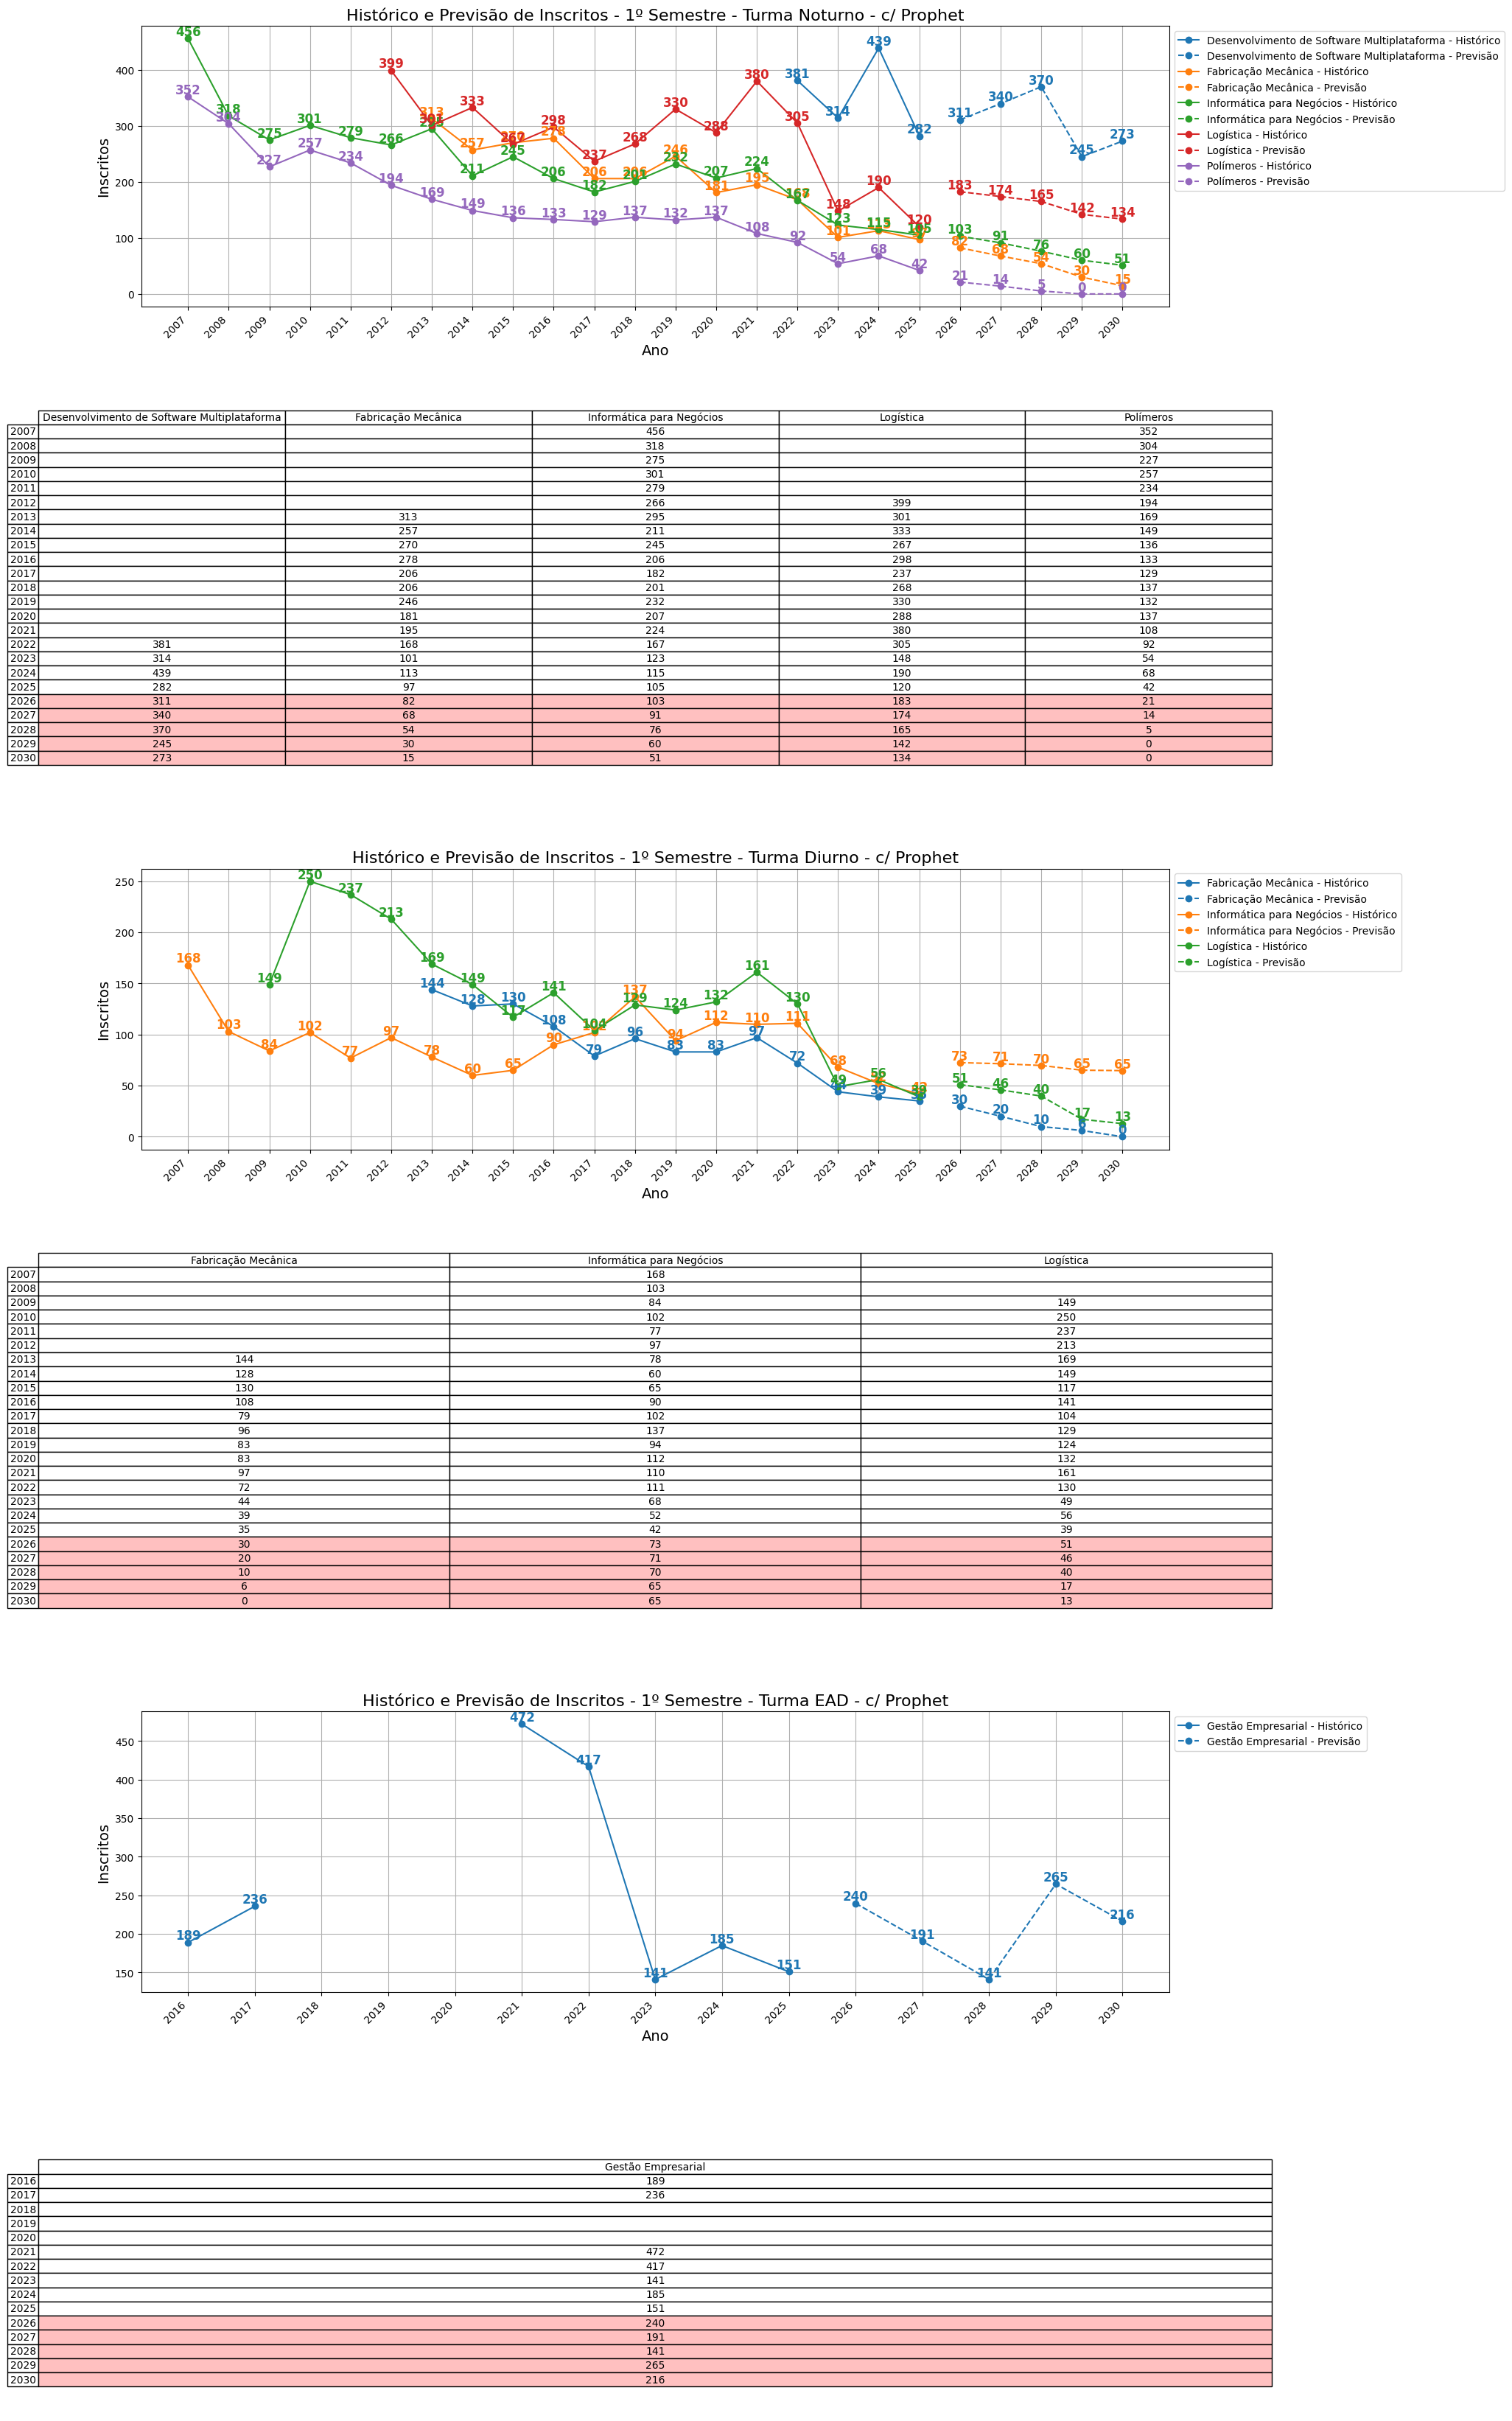

In [ ]:
# ALGORITMO PREVISAO COM PROPHET - DADOS 1 SEMESTRE - PREVISÃO C/ PROPHET


import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# isso tira as mensagens de warning e as do prophet e cmdstanpy
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_prophet = df_curso.rename(columns={'Ano': 'ds', 'Inscritos': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

        if len(df_prophet) < 3:
            continue

        modelo = Prophet(yearly_seasonality=True)
        modelo.fit(df_prophet)

        ultimo_ano = df_prophet['ds'].dt.year.max()
        future_years = list(range(ultimo_ano + 1, 2031))  # Ajustado para prever até 2030
        future_dates = pd.to_datetime([f'{ano}-01-01' for ano in future_years])
        future_df = pd.DataFrame({'ds': future_dates})

        forecast = modelo.predict(future_df)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        historico = df_prophet.copy()
        previsao = forecast

        anos_para_ticks.update(historico['ds'].dt.year.tolist())
        anos_para_ticks.update(previsao['ds'].dt.year.tolist())

        ax_grafico.plot(historico['ds'], historico['y'], marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(historico['ds'], historico['y']):
            ax_grafico.text(
                x, y,
                '' if pd.isna(y) else str(int(y)),
                fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i)
            )
        ax_grafico.plot(previsao['ds'], previsao['yhat'], marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(previsao['ds'], previsao['yhat']):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos = list(historico['ds'].dt.year) + list(previsao['ds'].dt.year)
        valores = list(historico['y']) + list(previsao['yhat'])
        for ano, valor in zip(anos, valores):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            if pd.notna(valor):
                tabela_dados[ano][curso] = int(round(valor))
            else:
                tabela_dados[ano][curso] = ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    xticks = [pd.to_datetime(f'{ano}-01-01') for ano in anos_para_ticks]
    ax_grafico.set_xticks(xticks)
    ax_grafico.set_xticklabels([str(ano.year) for ano in xticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ Prophet', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(
                lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x)
            )

        df_tabela = df_tabela.astype(str)

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


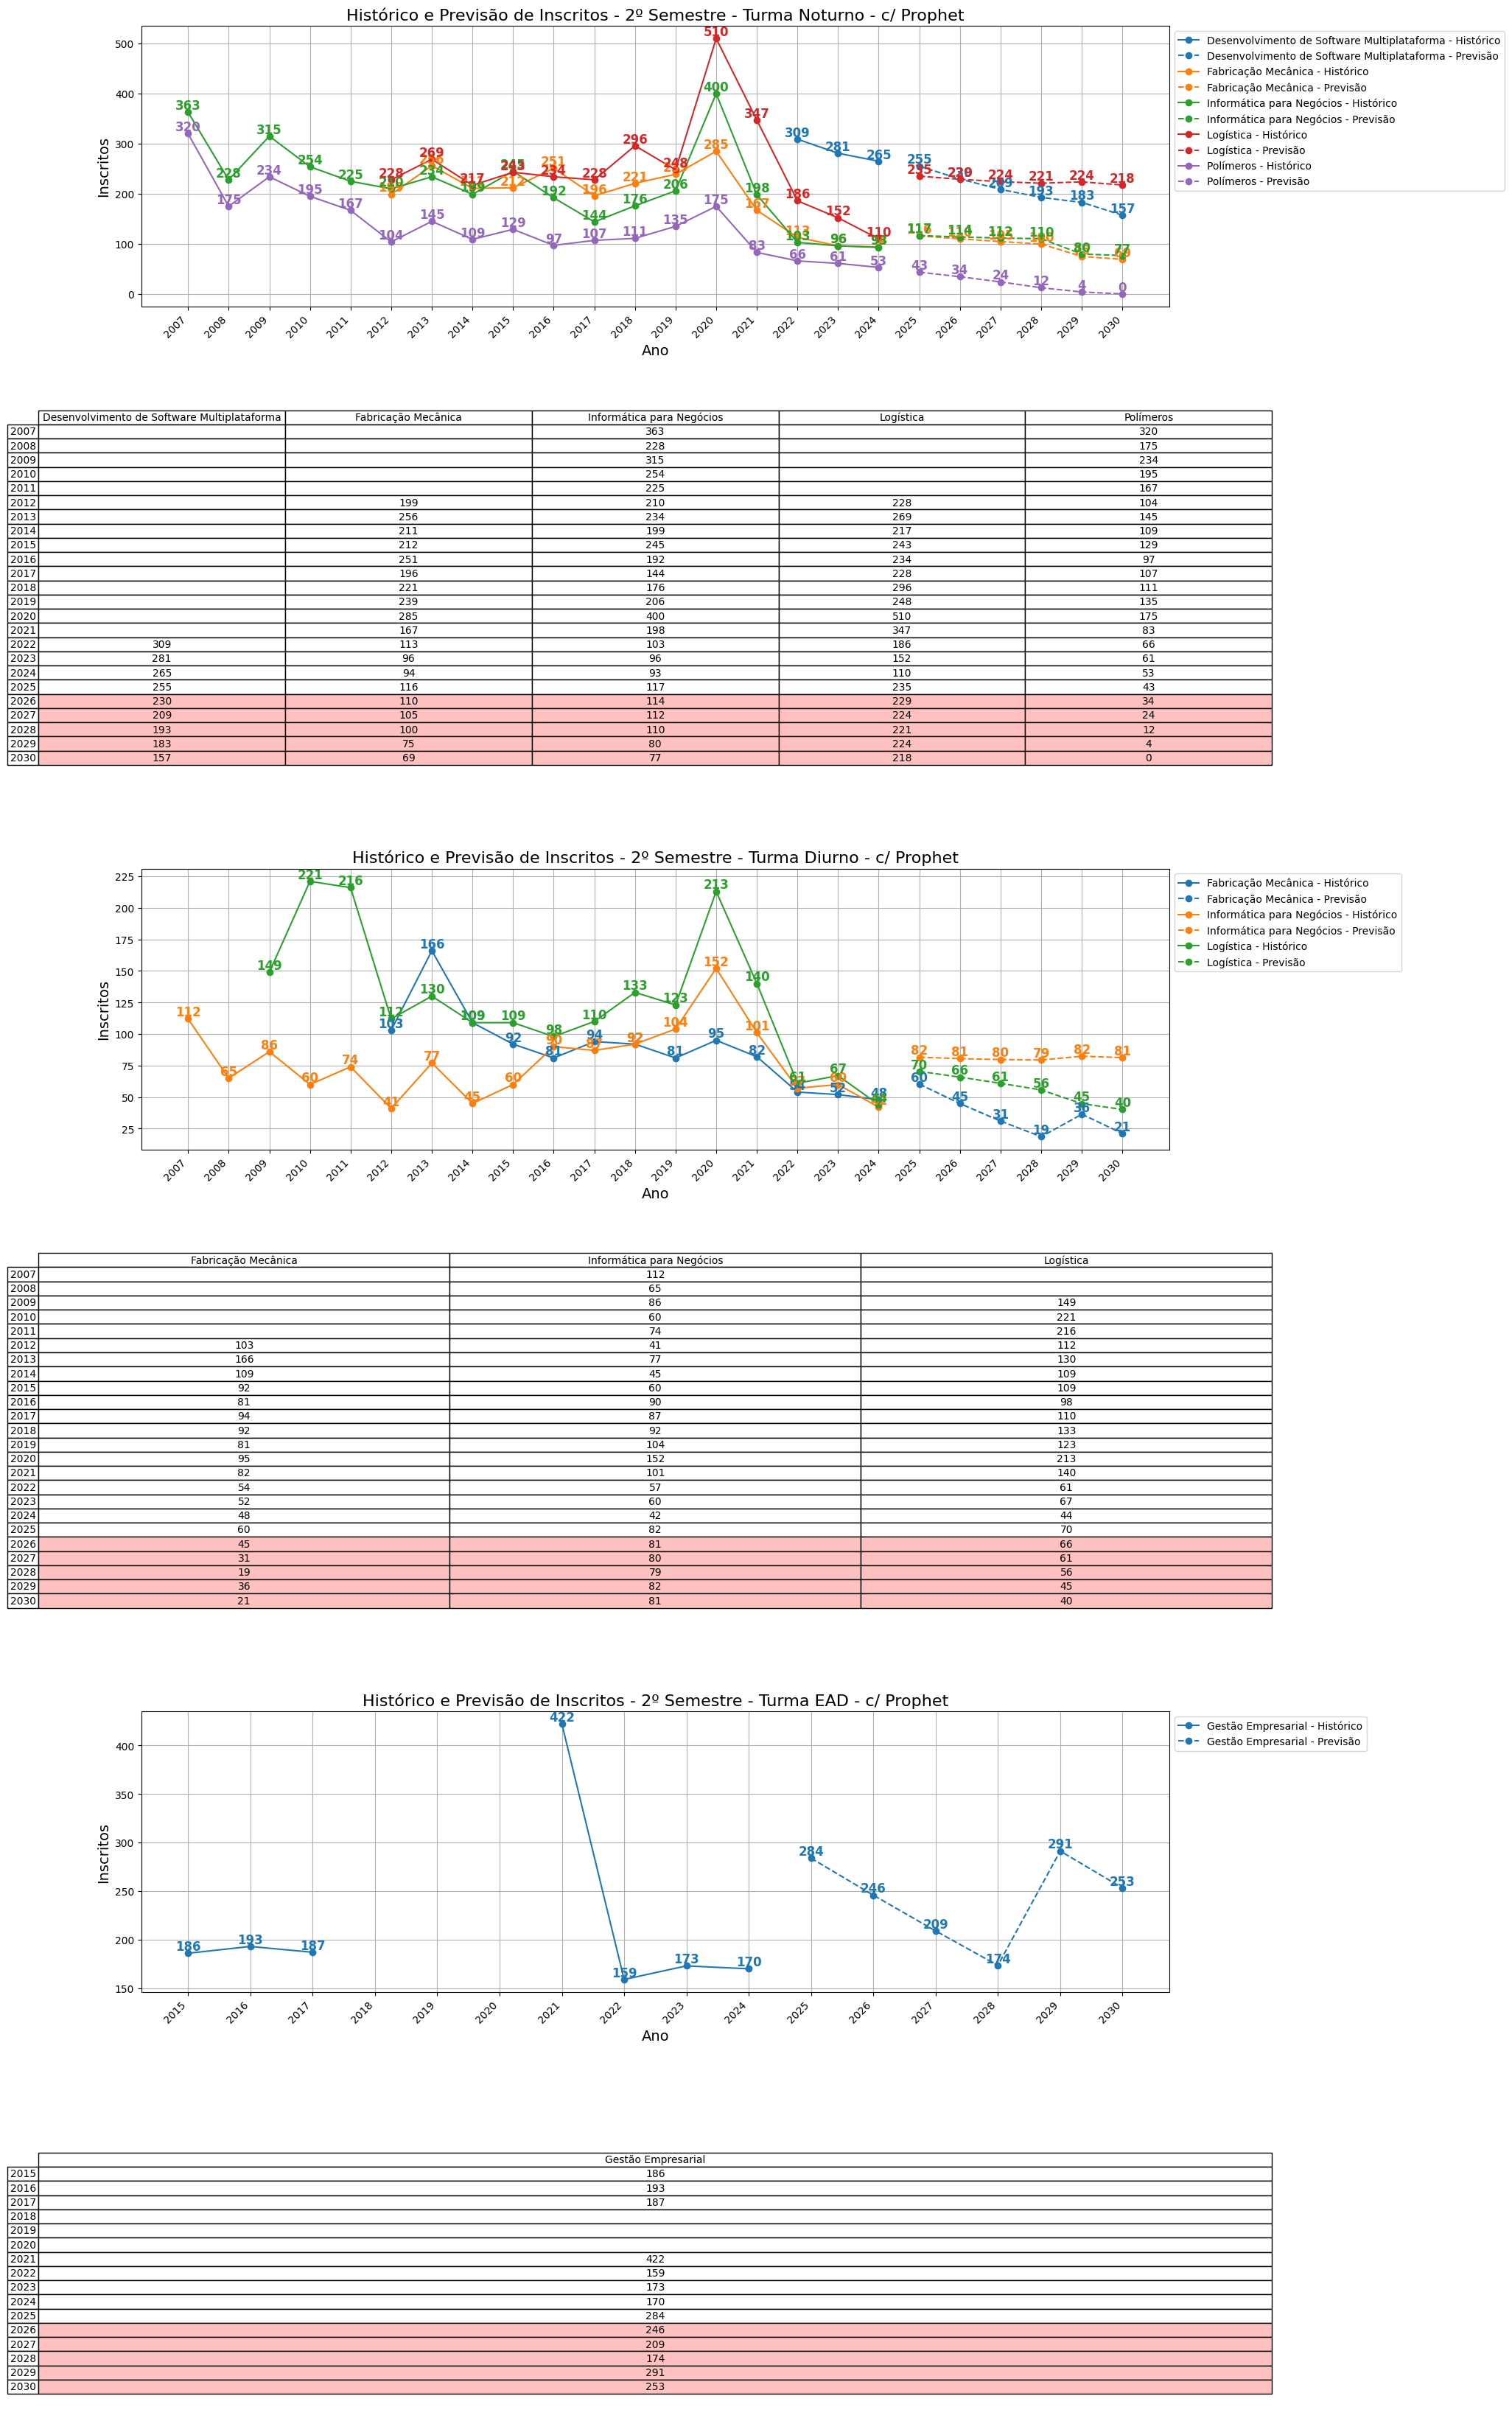

In [ ]:
# ALGORITMO PREVISAO COM PROPHET - DADOS 2 SEMESTRE - PREVISÃO C/ PROPHET


import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# isso tira as mensagens de warning e as do prophet e cmdstanpy
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 2
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_prophet = df_curso.rename(columns={'Ano': 'ds', 'Inscritos': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

        if len(df_prophet) < 3:
            continue

        modelo = Prophet(yearly_seasonality=True)
        modelo.fit(df_prophet)

        ultimo_ano = df_prophet['ds'].dt.year.max()
        future_years = list(range(ultimo_ano + 1, 2031))  # Ajustado para prever até 2030
        future_dates = pd.to_datetime([f'{ano}-01-01' for ano in future_years])
        future_df = pd.DataFrame({'ds': future_dates})

        forecast = modelo.predict(future_df)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        historico = df_prophet.copy()
        previsao = forecast

        anos_para_ticks.update(historico['ds'].dt.year.tolist())
        anos_para_ticks.update(previsao['ds'].dt.year.tolist())

        ax_grafico.plot(historico['ds'], historico['y'], marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(historico['ds'], historico['y']):
            ax_grafico.text(
                x, y,
                '' if pd.isna(y) else str(int(y)),
                fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i)
            )
        ax_grafico.plot(previsao['ds'], previsao['yhat'], marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(previsao['ds'], previsao['yhat']):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos = list(historico['ds'].dt.year) + list(previsao['ds'].dt.year)
        valores = list(historico['y']) + list(previsao['yhat'])
        for ano, valor in zip(anos, valores):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            if pd.notna(valor):
                tabela_dados[ano][curso] = int(round(valor))
            else:
                tabela_dados[ano][curso] = ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    xticks = [pd.to_datetime(f'{ano}-01-01') for ano in anos_para_ticks]
    ax_grafico.set_xticks(xticks)
    ax_grafico.set_xticklabels([str(ano.year) for ano in xticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 2º Semestre - Turma {turma} - c/ Prophet', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(
                lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x)
            )

        df_tabela = df_tabela.astype(str)

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


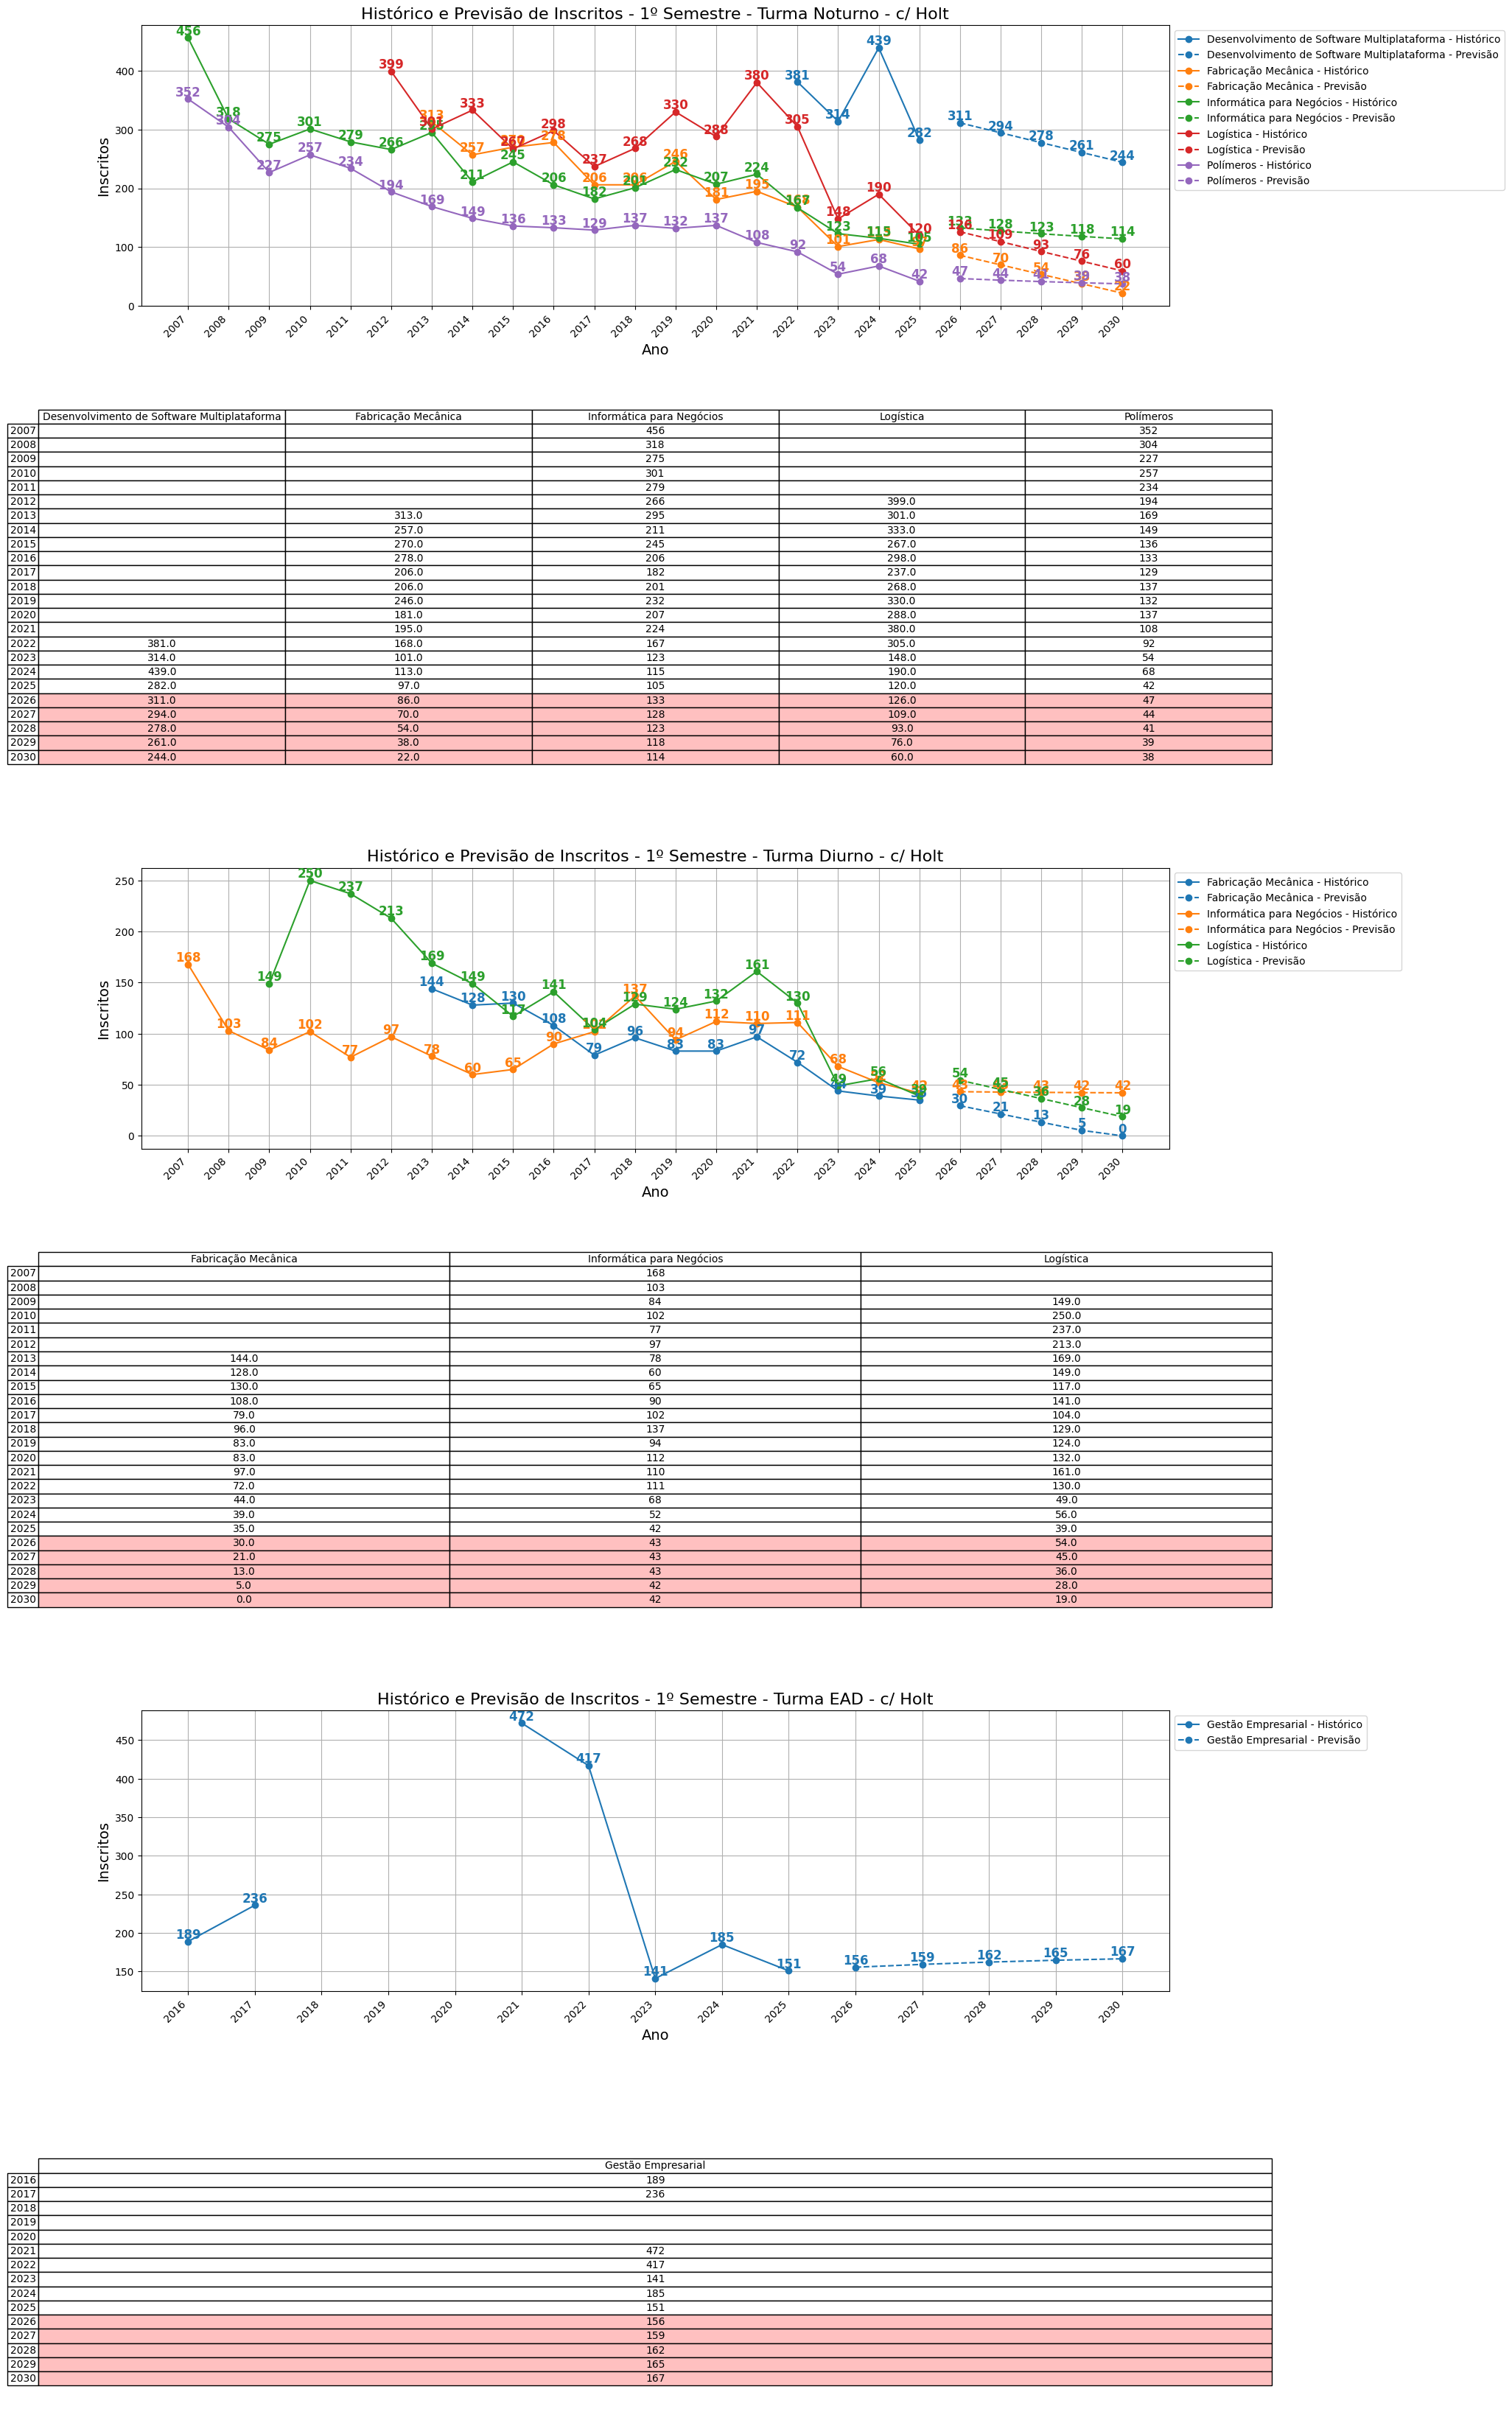

In [ ]:

# ALGORITMO PREVISAO COM HOLT - DADOS 1 SEMESTRE - PREVISÃO C/ HOLT


import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# isso tira as mensagens de warning
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
warnings.filterwarnings("ignore")

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        # Ajuste para EAD
        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # Preparar série temporal
        df_curso = df_curso.set_index('Ano').sort_index()
        y = df_curso['Inscritos']

        # Se poucos dados, pular previsão
        if len(y.dropna()) < 3:
            continue

        # Preencher NaNs por interpolação linear para suavizar
        y_interp = y.interpolate(method='linear')

        # Ajustar o modelo Holt com amortecimento
        try:
            modelo = ExponentialSmoothing(y_interp, trend='add', damped_trend=True, seasonal=None)
            ajuste = modelo.fit(optimized=True)
        except Exception as e:
            print(f"Erro no ajuste para {curso} na turma {turma}: {e}")
            continue

        # Previsão até 2030
        ultimo_ano = y.index.max()
        anos_futuros = list(range(ultimo_ano + 1, 2031))
        n_forecast = len(anos_futuros)

        forecast = ajuste.forecast(n_forecast)
        forecast = forecast.clip(lower=0)  # evitar previsões negativas

        # Dados históricos + previsão
        anos_todos = list(y.index) + anos_futuros
        valores_historico = y.values
        valores_previsao = forecast.values

        # Plot histórico
        ax_grafico.plot(y.index, valores_historico, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y_val in zip(y.index, valores_historico):
            if pd.notna(y_val):
                ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        # Plot previsão
        ax_grafico.plot(anos_futuros, valores_previsao, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y_val in zip(anos_futuros, valores_previsao):
            ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos_para_ticks.update(y.index.tolist())
        anos_para_ticks.update(anos_futuros)

        # Construir tabela
        for ano, valor in zip(y.index, valores_historico):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

        for ano, valor in zip(anos_futuros, valores_previsao):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ Holt', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        df_tabela = df_tabela.fillna('')

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


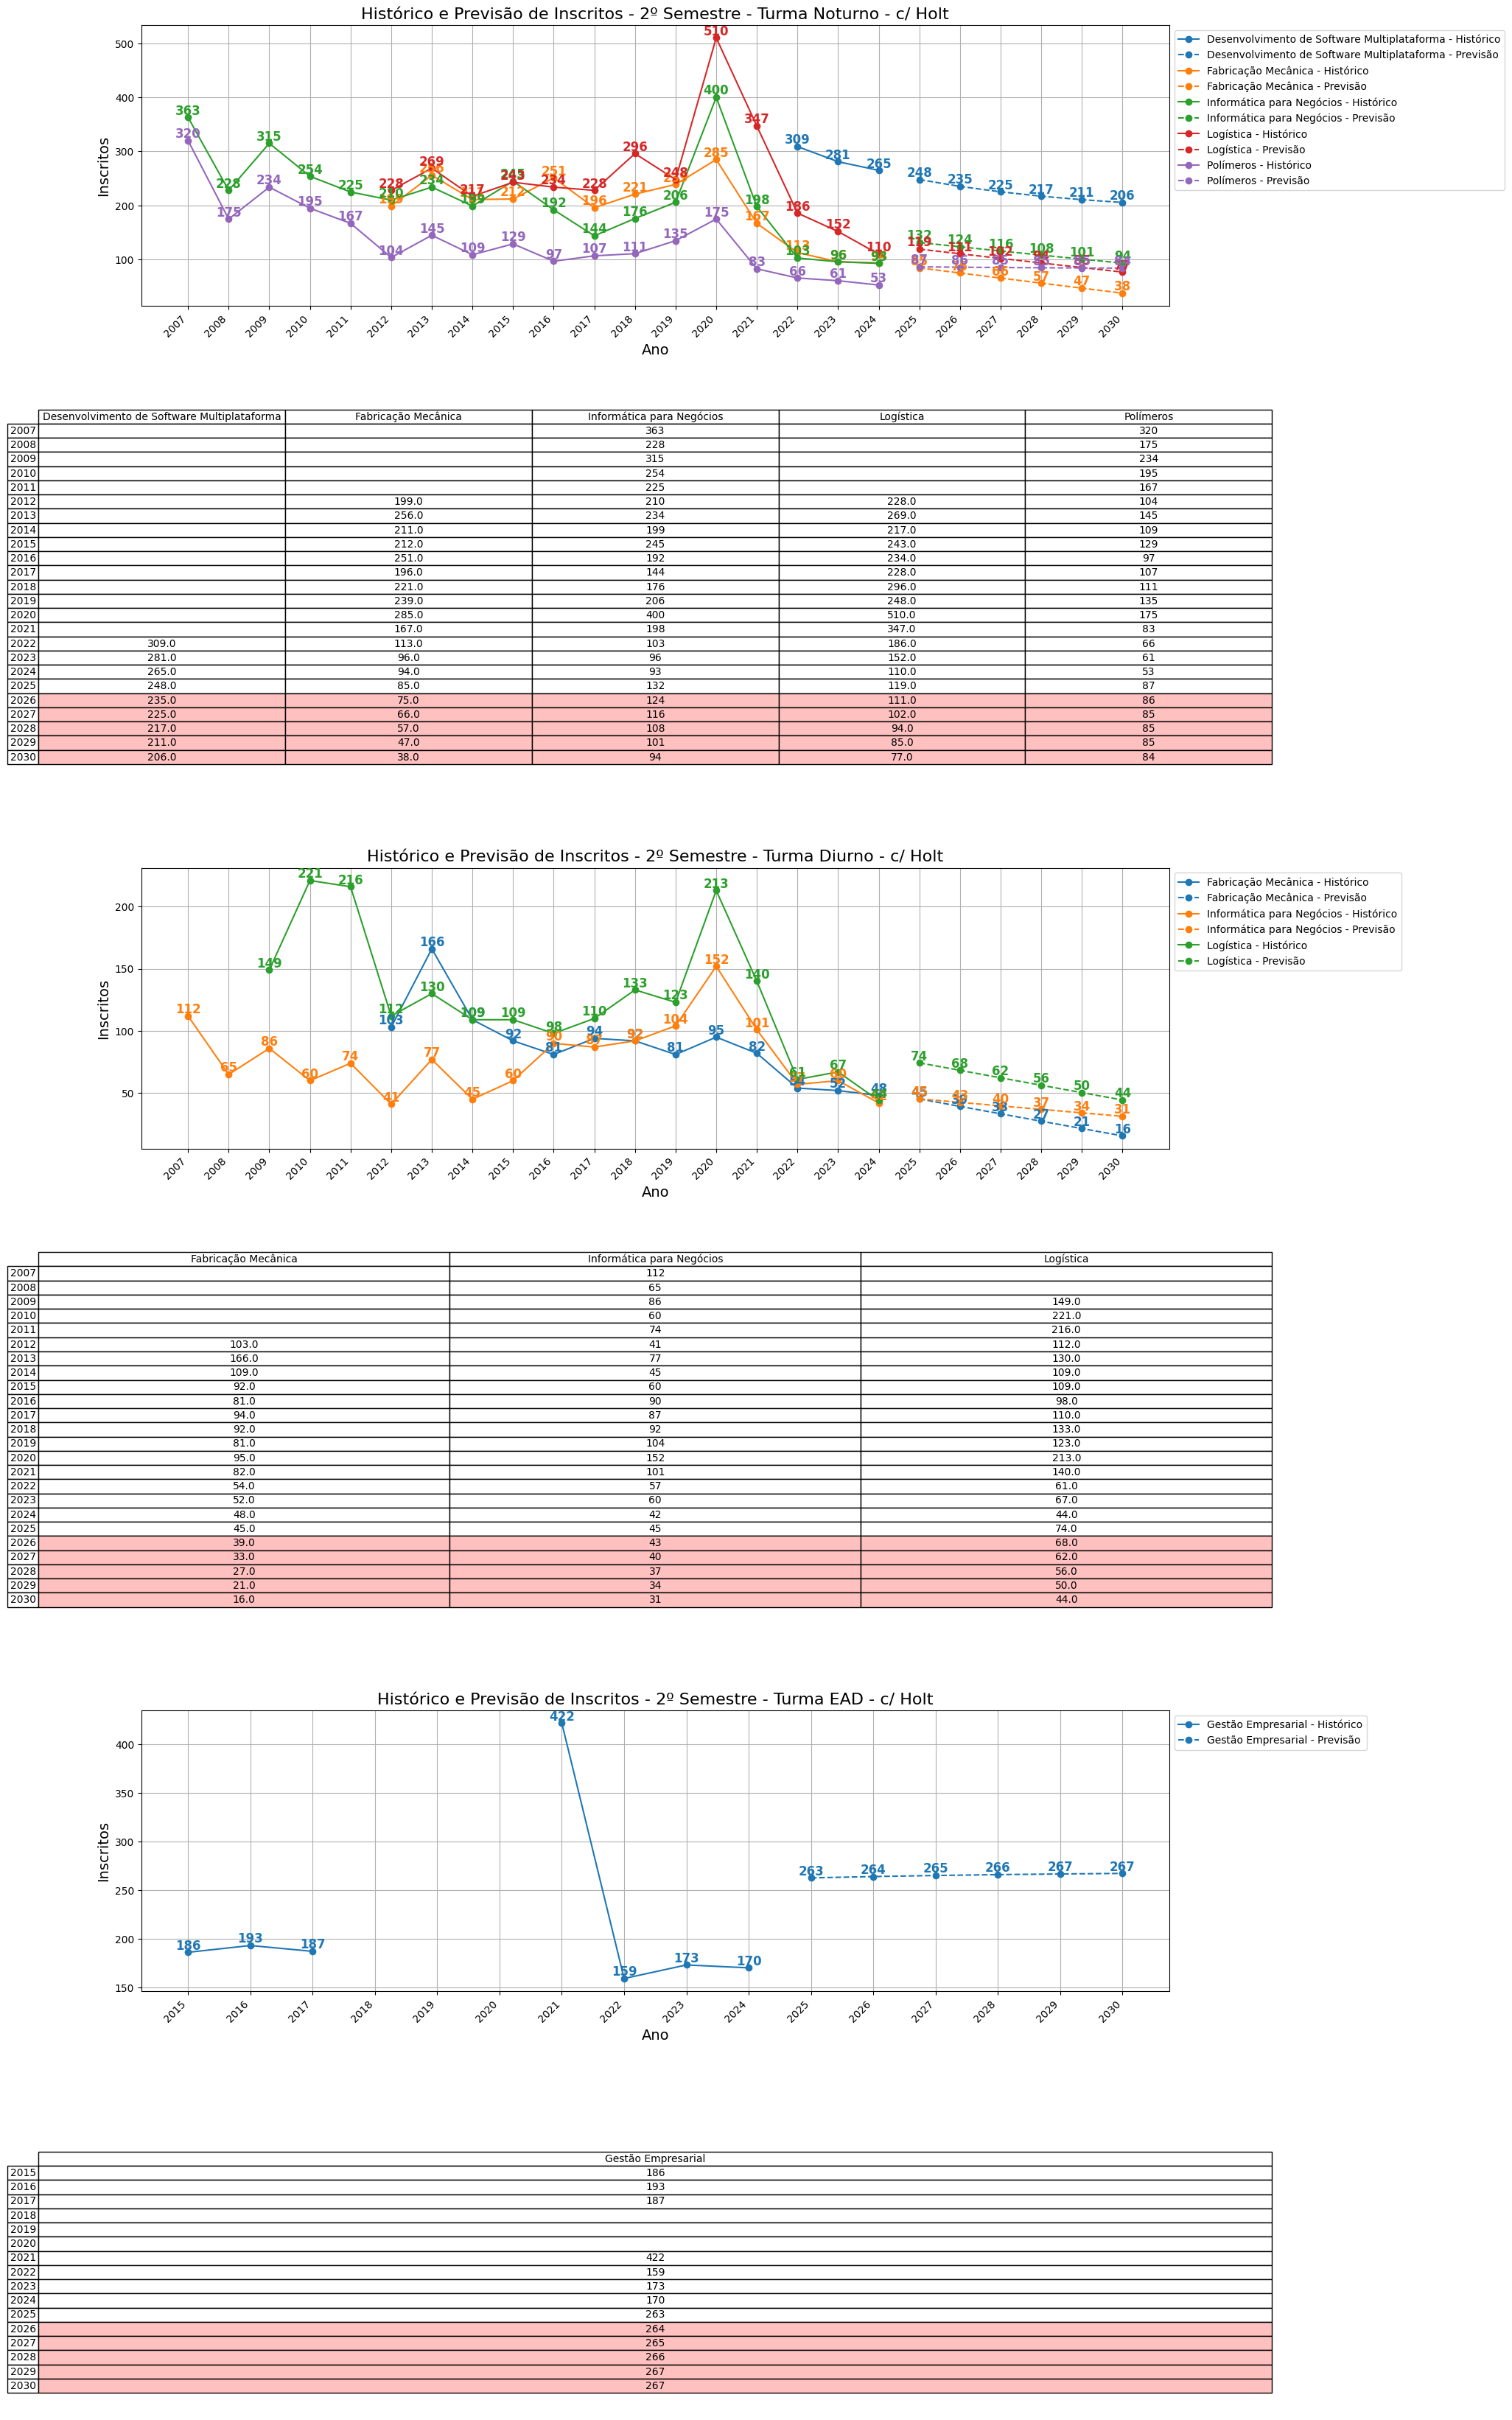

In [ ]:

# ALGORITMO PREVISAO COM HOLT - DADOS 2 SEMESTRE - PREVISÃO C/ HOLT


import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# isso tira as mensagens de warning
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
warnings.filterwarnings("ignore")

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        # Ajuste para EAD
        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # Preparar série temporal
        df_curso = df_curso.set_index('Ano').sort_index()
        y = df_curso['Inscritos']

        # Se poucos dados, pular previsão
        if len(y.dropna()) < 3:
            continue

        # Preencher NaNs por interpolação linear para suavizar
        y_interp = y.interpolate(method='linear')

        # Ajustar o modelo Holt com amortecimento
        try:
            modelo = ExponentialSmoothing(y_interp, trend='add', damped_trend=True, seasonal=None)
            ajuste = modelo.fit(optimized=True)
        except Exception as e:
            print(f"Erro no ajuste para {curso} na turma {turma}: {e}")
            continue

        # Previsão até 2030
        ultimo_ano = y.index.max()
        anos_futuros = list(range(ultimo_ano + 1, 2031))
        n_forecast = len(anos_futuros)

        forecast = ajuste.forecast(n_forecast)
        forecast = forecast.clip(lower=0)  # evitar previsões negativas

        # Dados históricos + previsão
        anos_todos = list(y.index) + anos_futuros
        valores_historico = y.values
        valores_previsao = forecast.values

        # Plot histórico
        ax_grafico.plot(y.index, valores_historico, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y_val in zip(y.index, valores_historico):
            if pd.notna(y_val):
                ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        # Plot previsão
        ax_grafico.plot(anos_futuros, valores_previsao, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y_val in zip(anos_futuros, valores_previsao):
            ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos_para_ticks.update(y.index.tolist())
        anos_para_ticks.update(anos_futuros)

        # Construir tabela
        for ano, valor in zip(y.index, valores_historico):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

        for ano, valor in zip(anos_futuros, valores_previsao):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 2º Semestre - Turma {turma} - c/ Holt', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        df_tabela = df_tabela.fillna('')

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

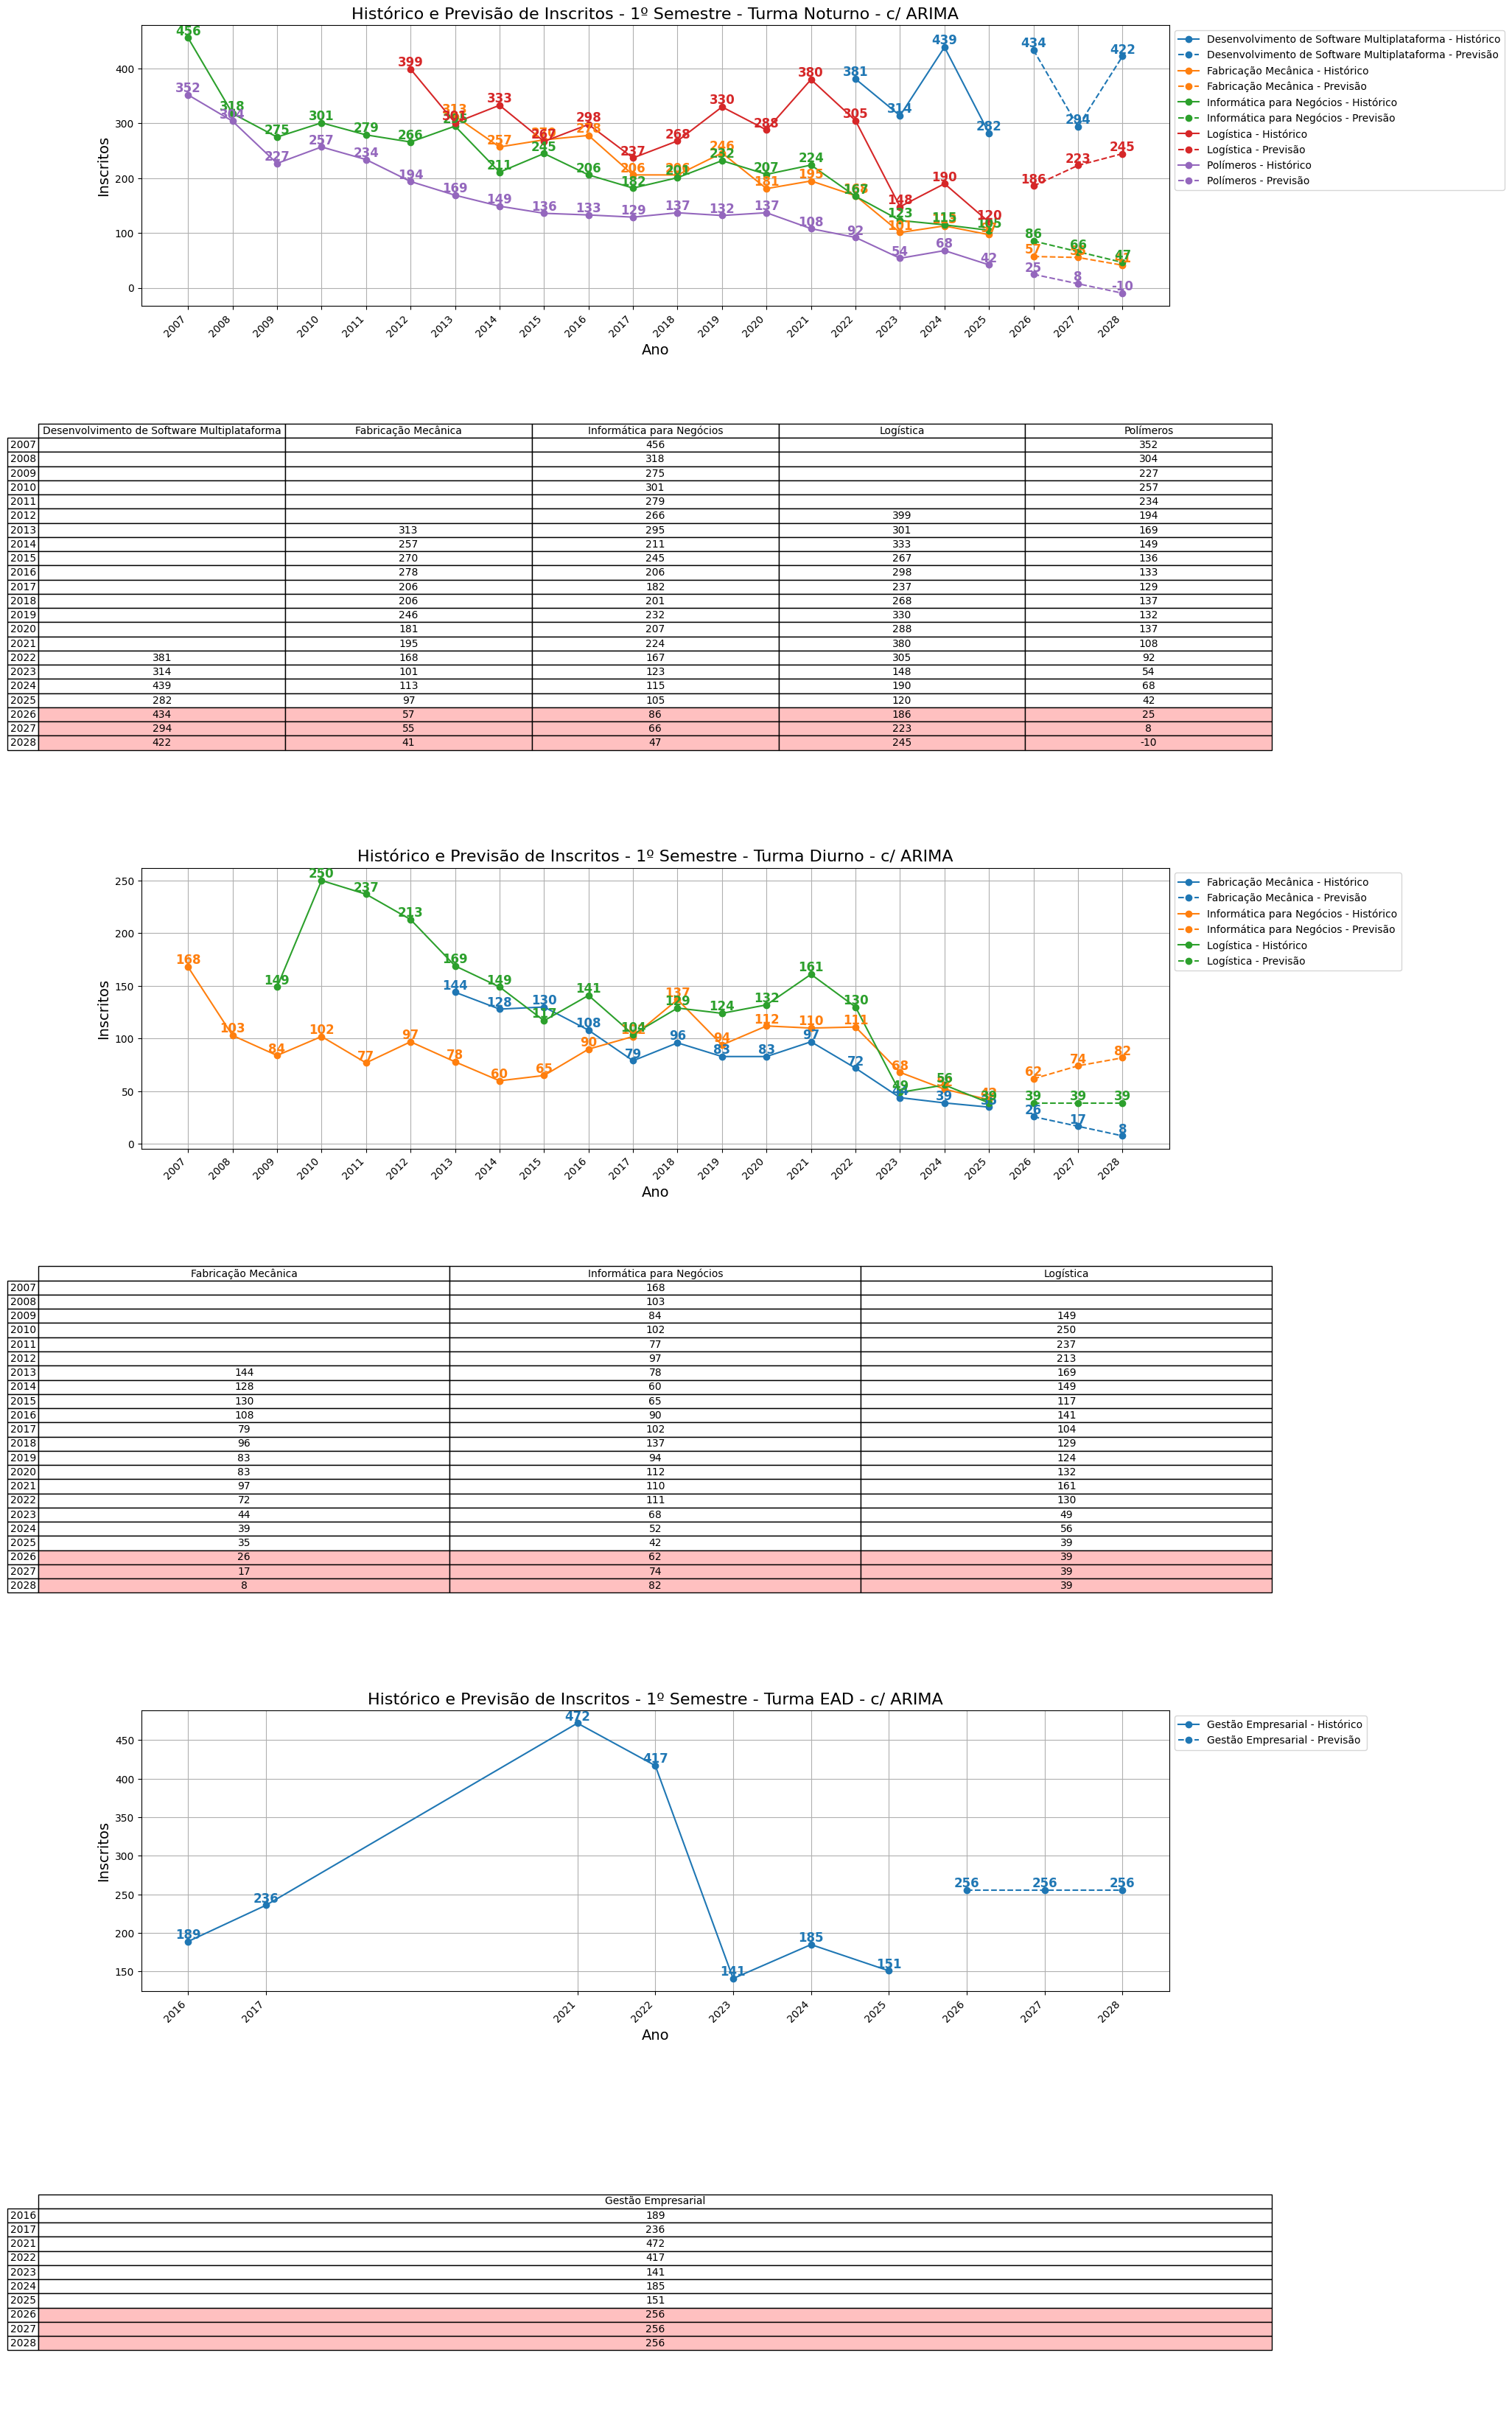

In [ ]:


# ALGORITMO PREVISAO COM ARIMA - DADOS 1 SEMESTRE

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib
import logging

from pmdarima import auto_arima
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_curso = df_curso.dropna()

        if len(df_curso) < 3:
            continue

        df_curso = df_curso.sort_values('Ano')
        serie = df_curso.set_index('Ano')['Inscritos']

        modelo = auto_arima(serie, seasonal=False, suppress_warnings=True)
        anos_existentes = serie.index.tolist()
        ultimo_ano = max(anos_existentes)

        anos_futuros = list(range(ultimo_ano + 1, 2029))
        n_periodos = len(anos_futuros)
        previsoes = modelo.predict(n_periods=n_periodos)

        anos_total = anos_existentes + anos_futuros
        valores_total = list(serie.values) + list(previsoes)

        ax_grafico.plot(anos_existentes, serie.values, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(anos_existentes, serie.values):
            ax_grafico.text(x, y, str(int(y)), fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        ax_grafico.plot(anos_futuros, previsoes, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(anos_futuros, previsoes):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        for ano, valor in zip(anos_total, valores_total):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if not pd.isna(valor) else ''

        anos_para_ticks.update(anos_total)

    # Eixo X
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ ARIMA', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Tabela abaixo
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x))

        df_tabela = df_tabela.astype(str)

        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

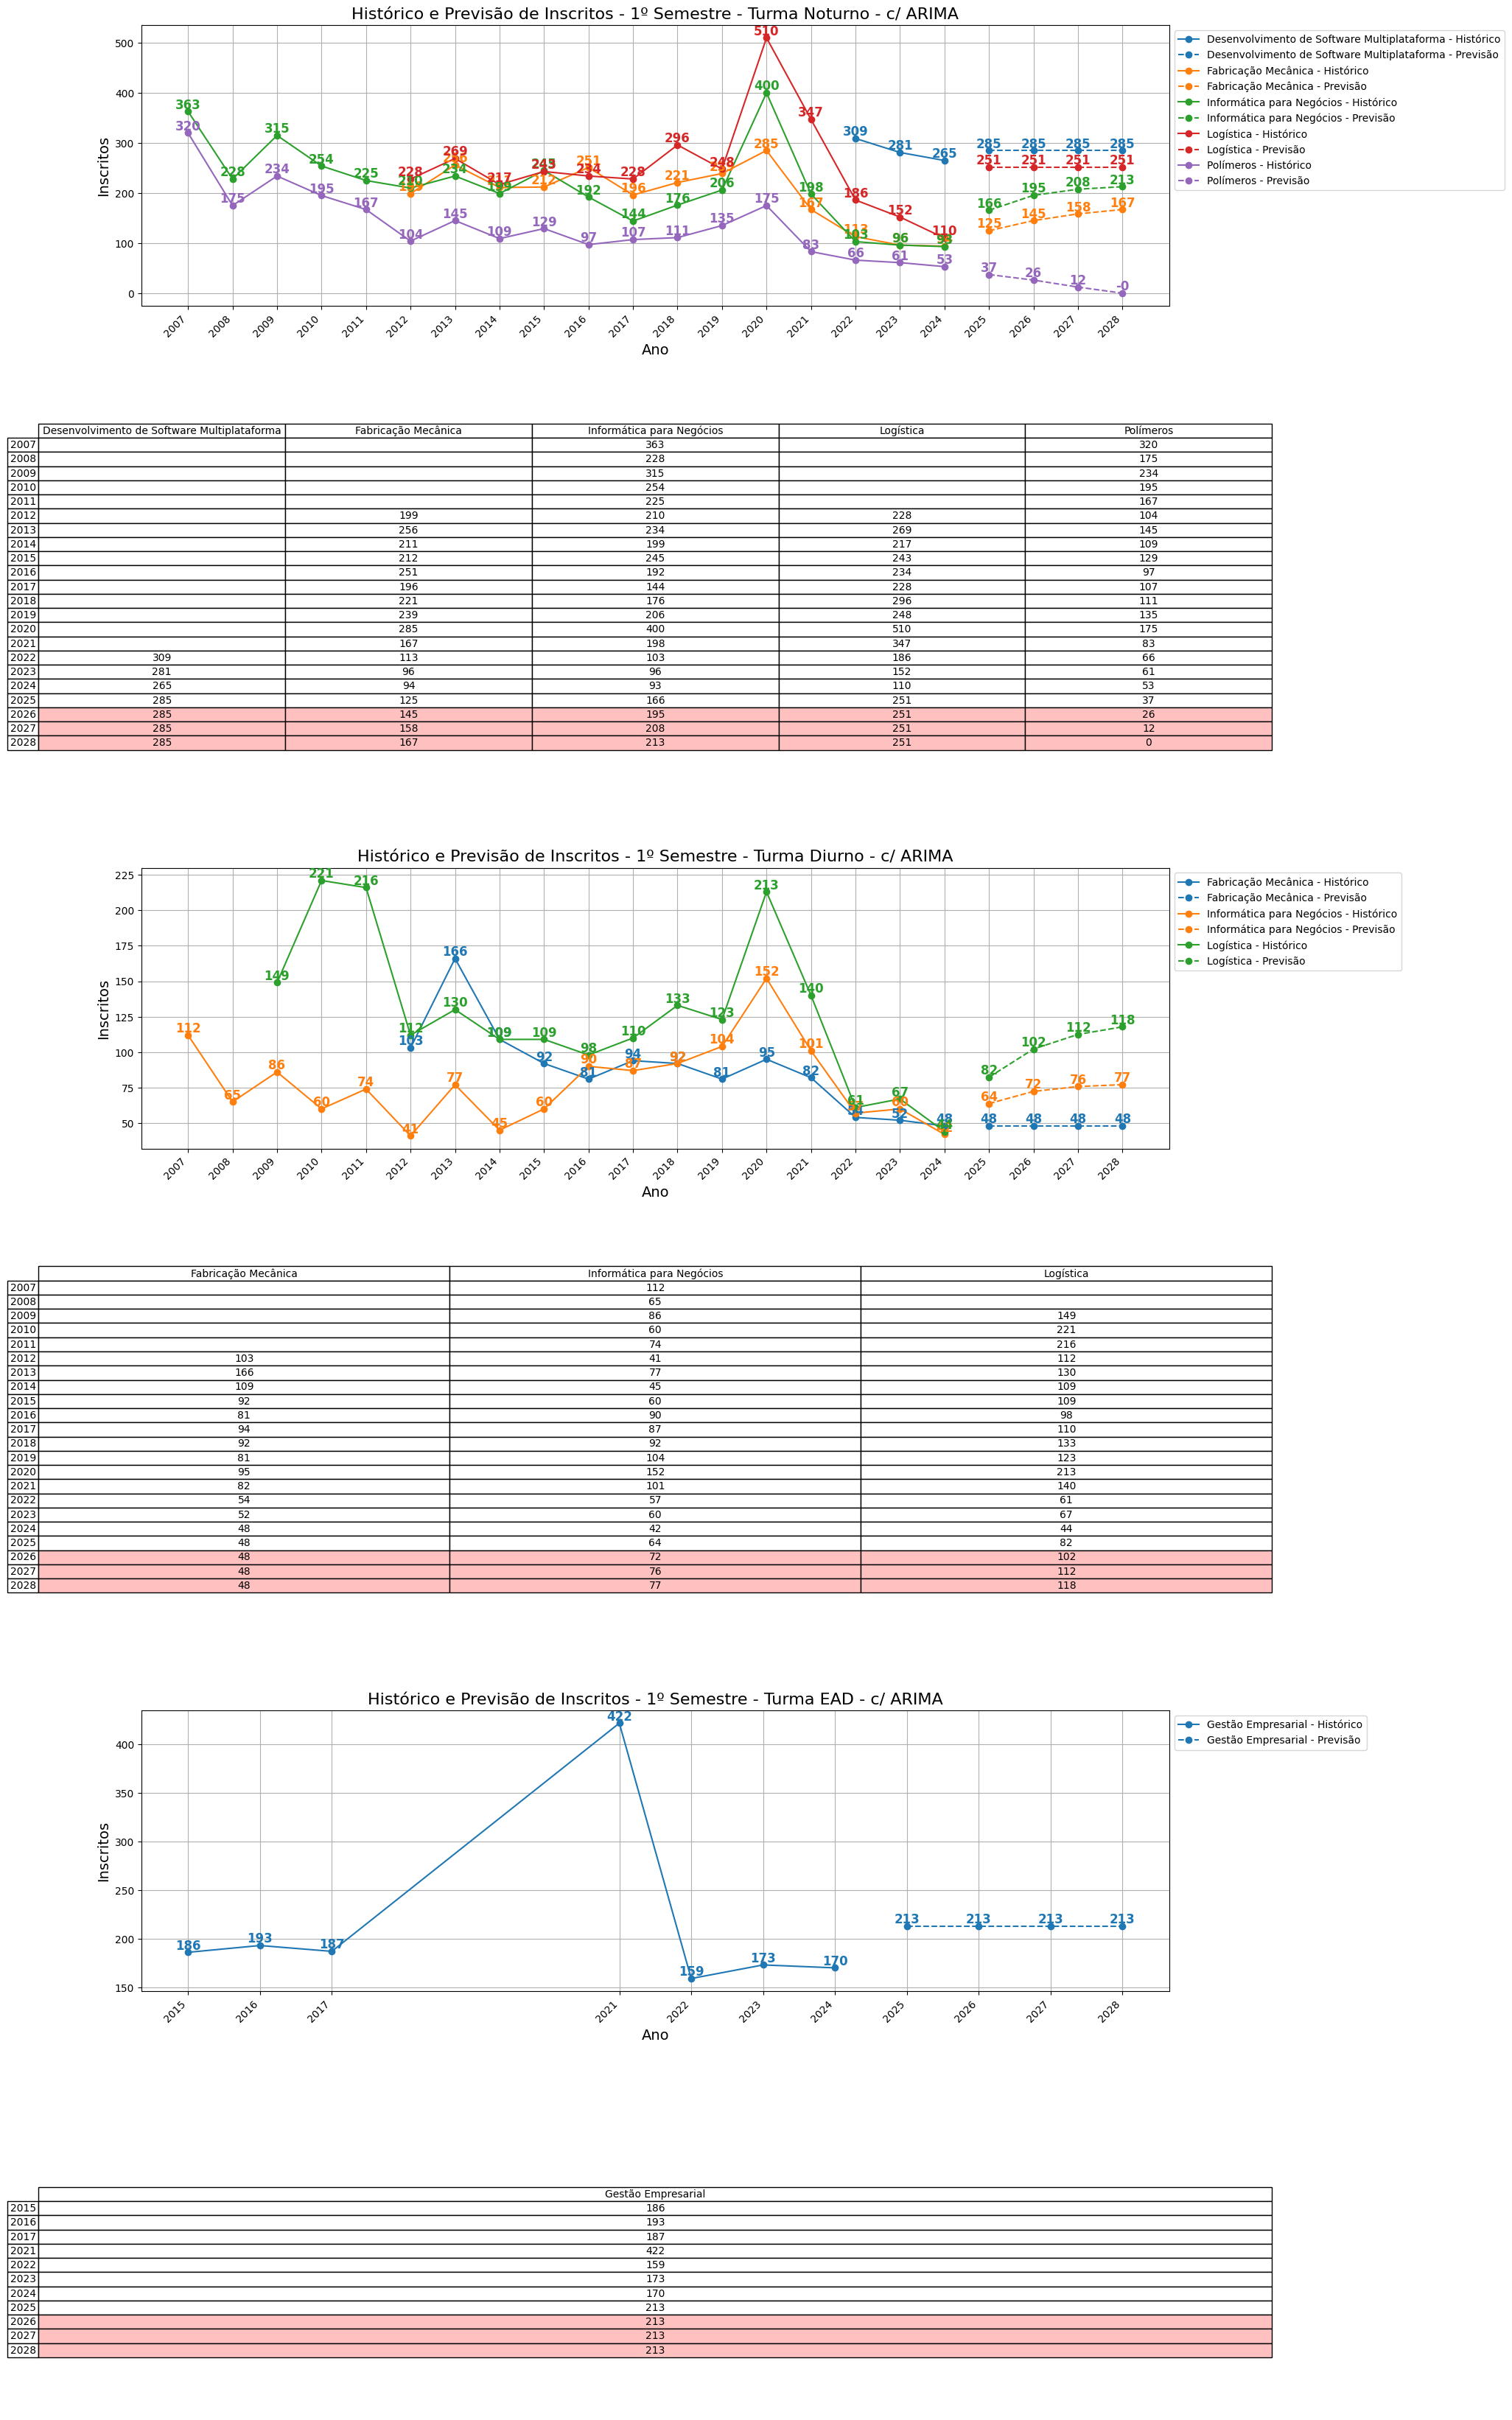

In [ ]:


# ALGORITMO PREVISAO COM ARIMA - DADOS 2 SEMESTRE

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib
import logging

from pmdarima import auto_arima
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_curso = df_curso.dropna()

        if len(df_curso) < 3:
            continue

        df_curso = df_curso.sort_values('Ano')
        serie = df_curso.set_index('Ano')['Inscritos']

        modelo = auto_arima(serie, seasonal=False, suppress_warnings=True)
        anos_existentes = serie.index.tolist()
        ultimo_ano = max(anos_existentes)

        anos_futuros = list(range(ultimo_ano + 1, 2029))
        n_periodos = len(anos_futuros)
        previsoes = modelo.predict(n_periods=n_periodos)

        anos_total = anos_existentes + anos_futuros
        valores_total = list(serie.values) + list(previsoes)

        ax_grafico.plot(anos_existentes, serie.values, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(anos_existentes, serie.values):
            ax_grafico.text(x, y, str(int(y)), fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        ax_grafico.plot(anos_futuros, previsoes, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(anos_futuros, previsoes):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        for ano, valor in zip(anos_total, valores_total):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if not pd.isna(valor) else ''

        anos_para_ticks.update(anos_total)

    # Eixo X
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ ARIMA', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Tabela abaixo
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x))

        df_tabela = df_tabela.astype(str)

        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


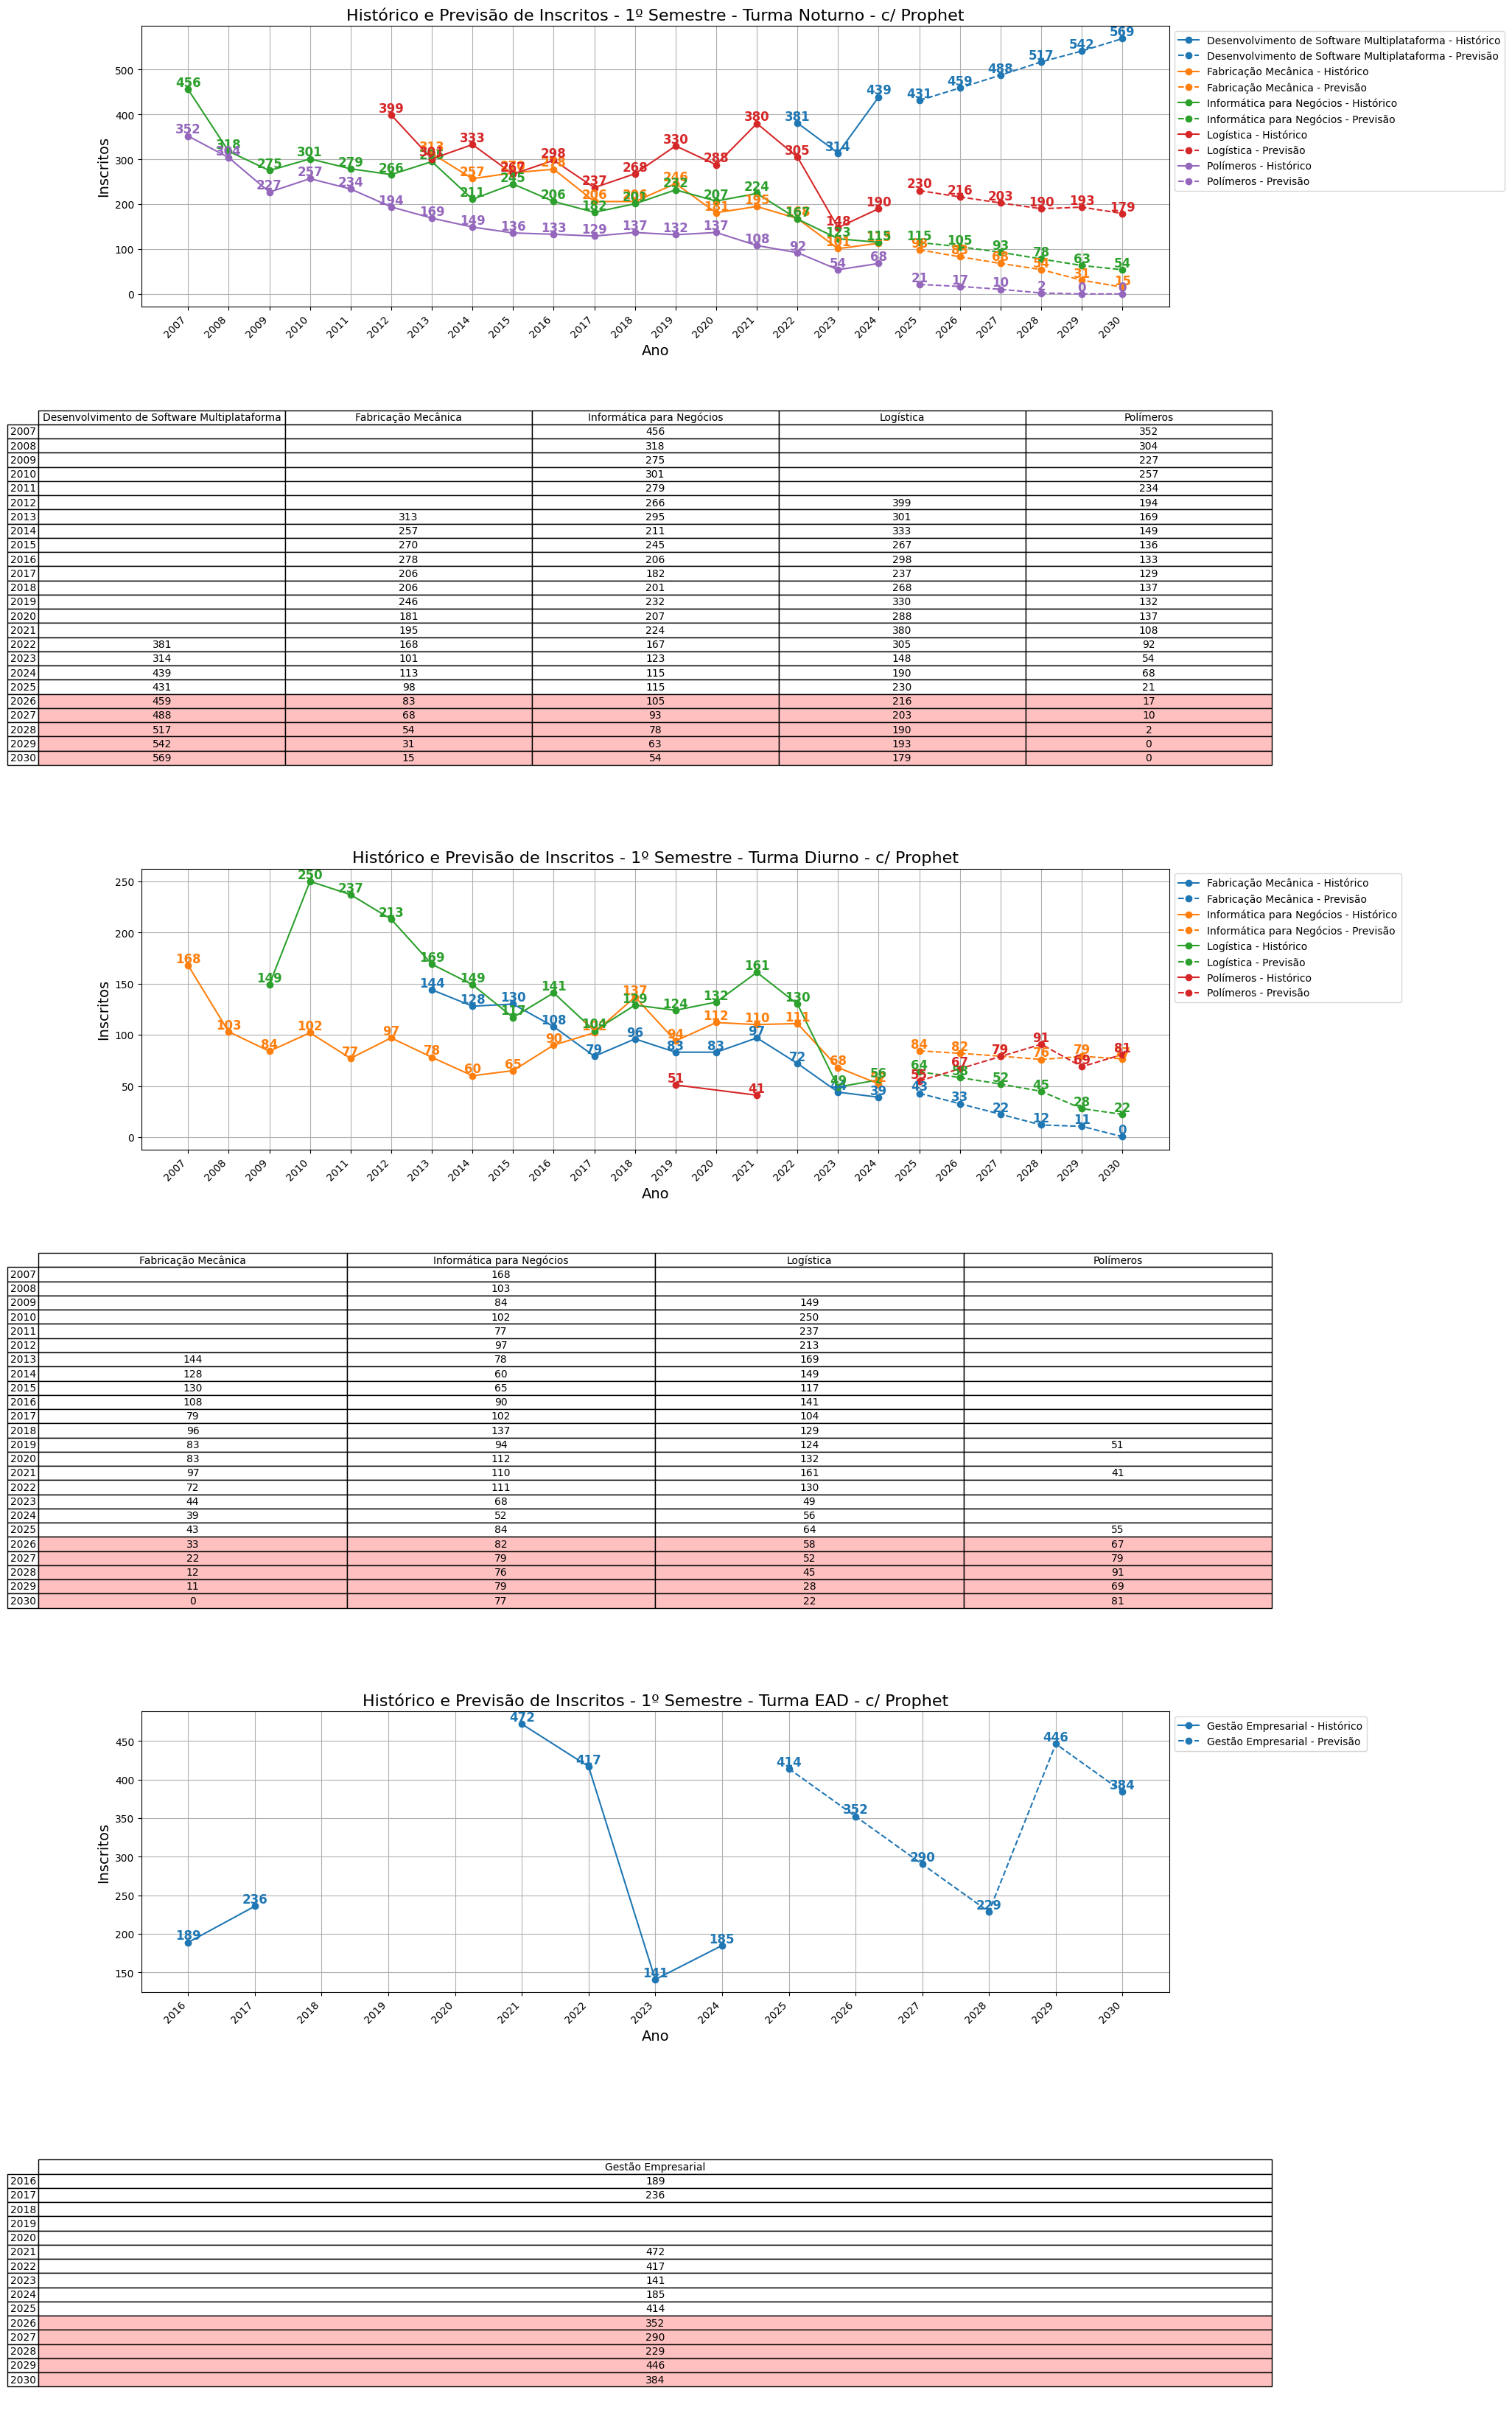

In [ ]:
# ALGORITMO PREVISAO COM PROPHET - DADOS 1 SEMESTRE - PREVISÃO C/ PROPHET  - historico até 2023 e previsão após

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# isso tira as mensagens de warning e as do prophet e cmdstanpy
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]}),
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # ✅ Filtrar dados históricos até 2023
        df_curso = df_curso[df_curso['Ano'] <= 2024]

        df_prophet = df_curso.rename(columns={'Ano': 'ds', 'Inscritos': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

        if len(df_prophet) < 2:
            continue

        modelo = Prophet(yearly_seasonality=True)
        modelo.fit(df_prophet)

        ultimo_ano = df_prophet['ds'].dt.year.max()
        future_years = list(range(2025, 2031))  # Previsão de 2024 até 2030
        future_dates = pd.to_datetime([f'{ano}-01-01' for ano in future_years])
        future_df = pd.DataFrame({'ds': future_dates})

        forecast = modelo.predict(future_df)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        historico = df_prophet.copy()
        previsao = forecast

        anos_para_ticks.update(historico['ds'].dt.year.tolist())
        anos_para_ticks.update(previsao['ds'].dt.year.tolist())

        ax_grafico.plot(historico['ds'], historico['y'], marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(historico['ds'], historico['y']):
            ax_grafico.text(
                x, y,
                '' if pd.isna(y) else str(int(y)),
                fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i)
            )
        ax_grafico.plot(previsao['ds'], previsao['yhat'], marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(previsao['ds'], previsao['yhat']):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos = list(historico['ds'].dt.year) + list(previsao['ds'].dt.year)
        valores = list(historico['y']) + list(previsao['yhat'])
        for ano, valor in zip(anos, valores):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            if pd.notna(valor):
                tabela_dados[ano][curso] = int(round(valor))
            else:
                tabela_dados[ano][curso] = ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    xticks = [pd.to_datetime(f'{ano}-01-01') for ano in anos_para_ticks]
    ax_grafico.set_xticks(xticks)
    ax_grafico.set_xticklabels([str(ano.year) for ano in xticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ Prophet', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(
                lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x)
            )

        df_tabela = df_tabela.astype(str)

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


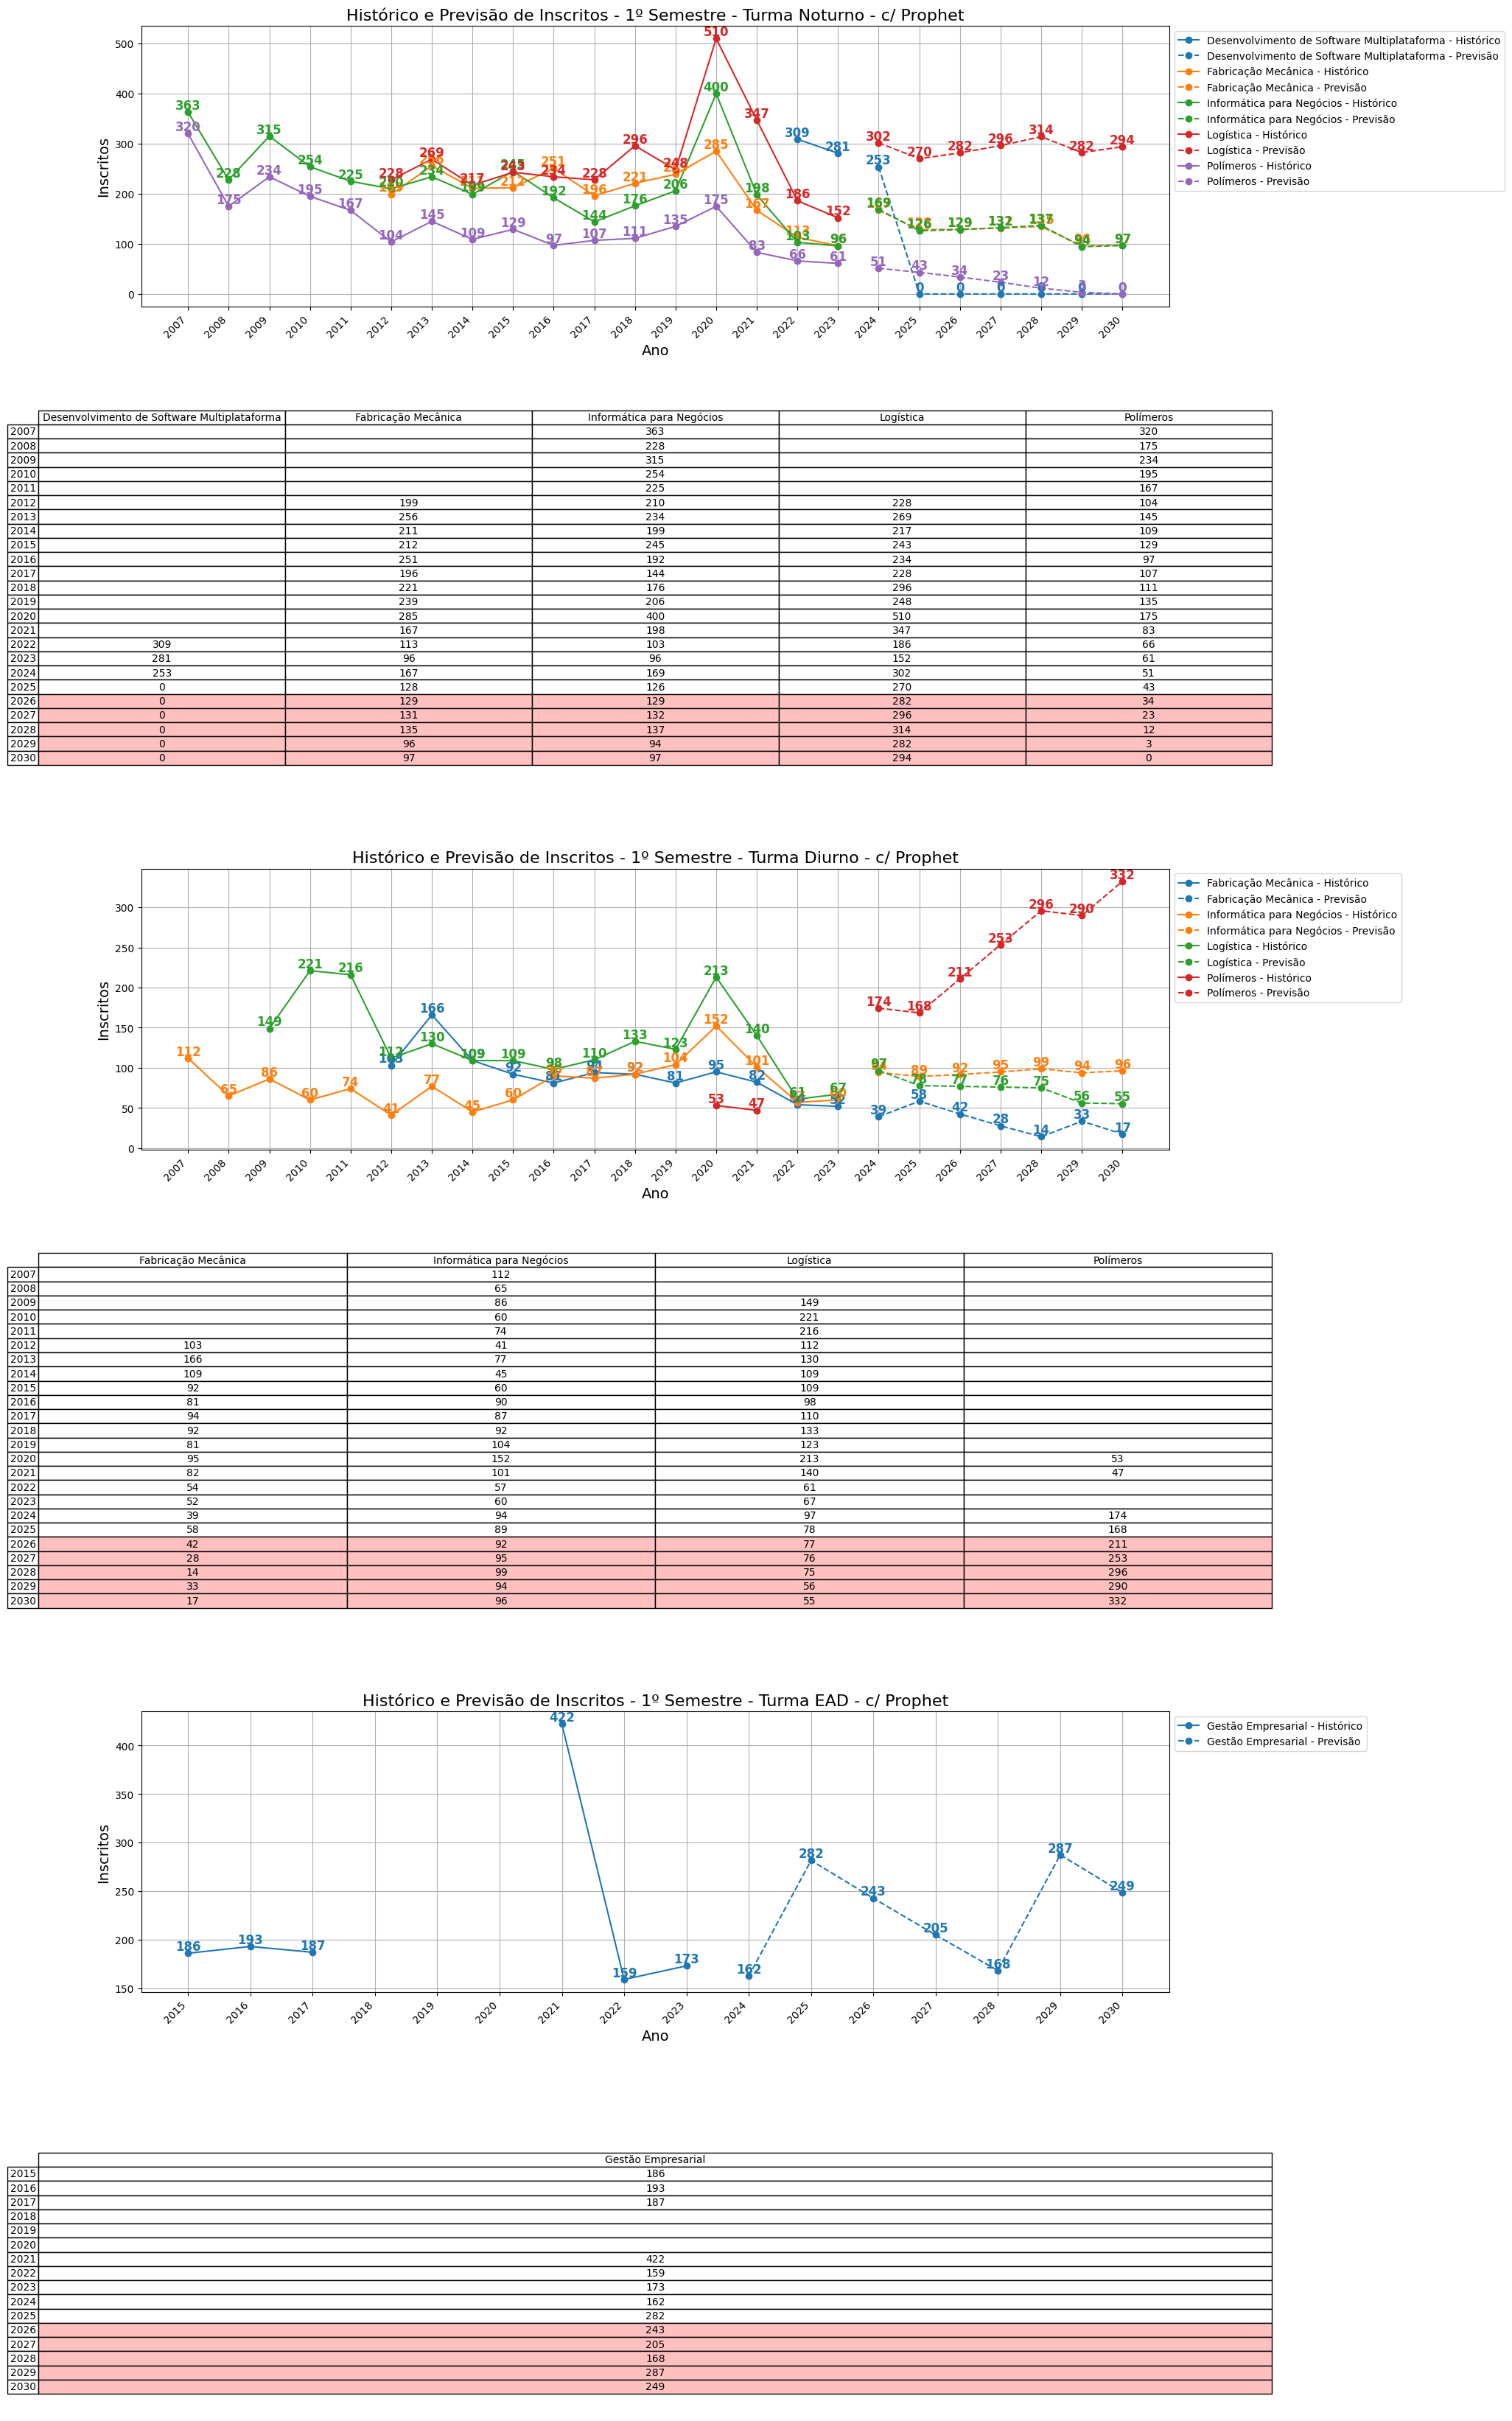

In [ ]:
# ALGORITMO PREVISAO COM PROPHET - DADOS 2 SEMESTRE - PREVISÃO C/ PROPHET  - historico até 2023 e previsão após

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# isso tira as mensagens de warning e as do prophet e cmdstanpy
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

# Se só uma turma, axs pode não ser lista, garantir lista para iteração
if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]}),
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # ✅ Filtrar dados históricos até 2023
        df_curso = df_curso[df_curso['Ano'] <= 2023]

        df_prophet = df_curso.rename(columns={'Ano': 'ds', 'Inscritos': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

        if len(df_prophet) < 2:
            continue

        modelo = Prophet(yearly_seasonality=True)
        modelo.fit(df_prophet)

        ultimo_ano = df_prophet['ds'].dt.year.max()
        future_years = list(range(2024, 2031))  # Previsão de 2024 até 2030
        future_dates = pd.to_datetime([f'{ano}-01-01' for ano in future_years])
        future_df = pd.DataFrame({'ds': future_dates})

        forecast = modelo.predict(future_df)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        historico = df_prophet.copy()
        previsao = forecast

        anos_para_ticks.update(historico['ds'].dt.year.tolist())
        anos_para_ticks.update(previsao['ds'].dt.year.tolist())

        ax_grafico.plot(historico['ds'], historico['y'], marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(historico['ds'], historico['y']):
            ax_grafico.text(
                x, y,
                '' if pd.isna(y) else str(int(y)),
                fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i)
            )
        ax_grafico.plot(previsao['ds'], previsao['yhat'], marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(previsao['ds'], previsao['yhat']):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        anos = list(historico['ds'].dt.year) + list(previsao['ds'].dt.year)
        valores = list(historico['y']) + list(previsao['yhat'])
        for ano, valor in zip(anos, valores):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            if pd.notna(valor):
                tabela_dados[ano][curso] = int(round(valor))
            else:
                tabela_dados[ano][curso] = ''

    # Configurar eixo X do gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    xticks = [pd.to_datetime(f'{ano}-01-01') for ano in anos_para_ticks]
    ax_grafico.set_xticks(xticks)
    ax_grafico.set_xticklabels([str(ano.year) for ano in xticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ Prophet', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Preparar e exibir tabela logo abaixo do gráfico
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(
                lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x)
            )

        df_tabela = df_tabela.astype(str)

        # Definir cores das linhas 2026 até 2030 (fundo vermelho clarinho)
        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028, 2029, 2030]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

# Ajustar espaçamentos para evitar sobreposição
plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


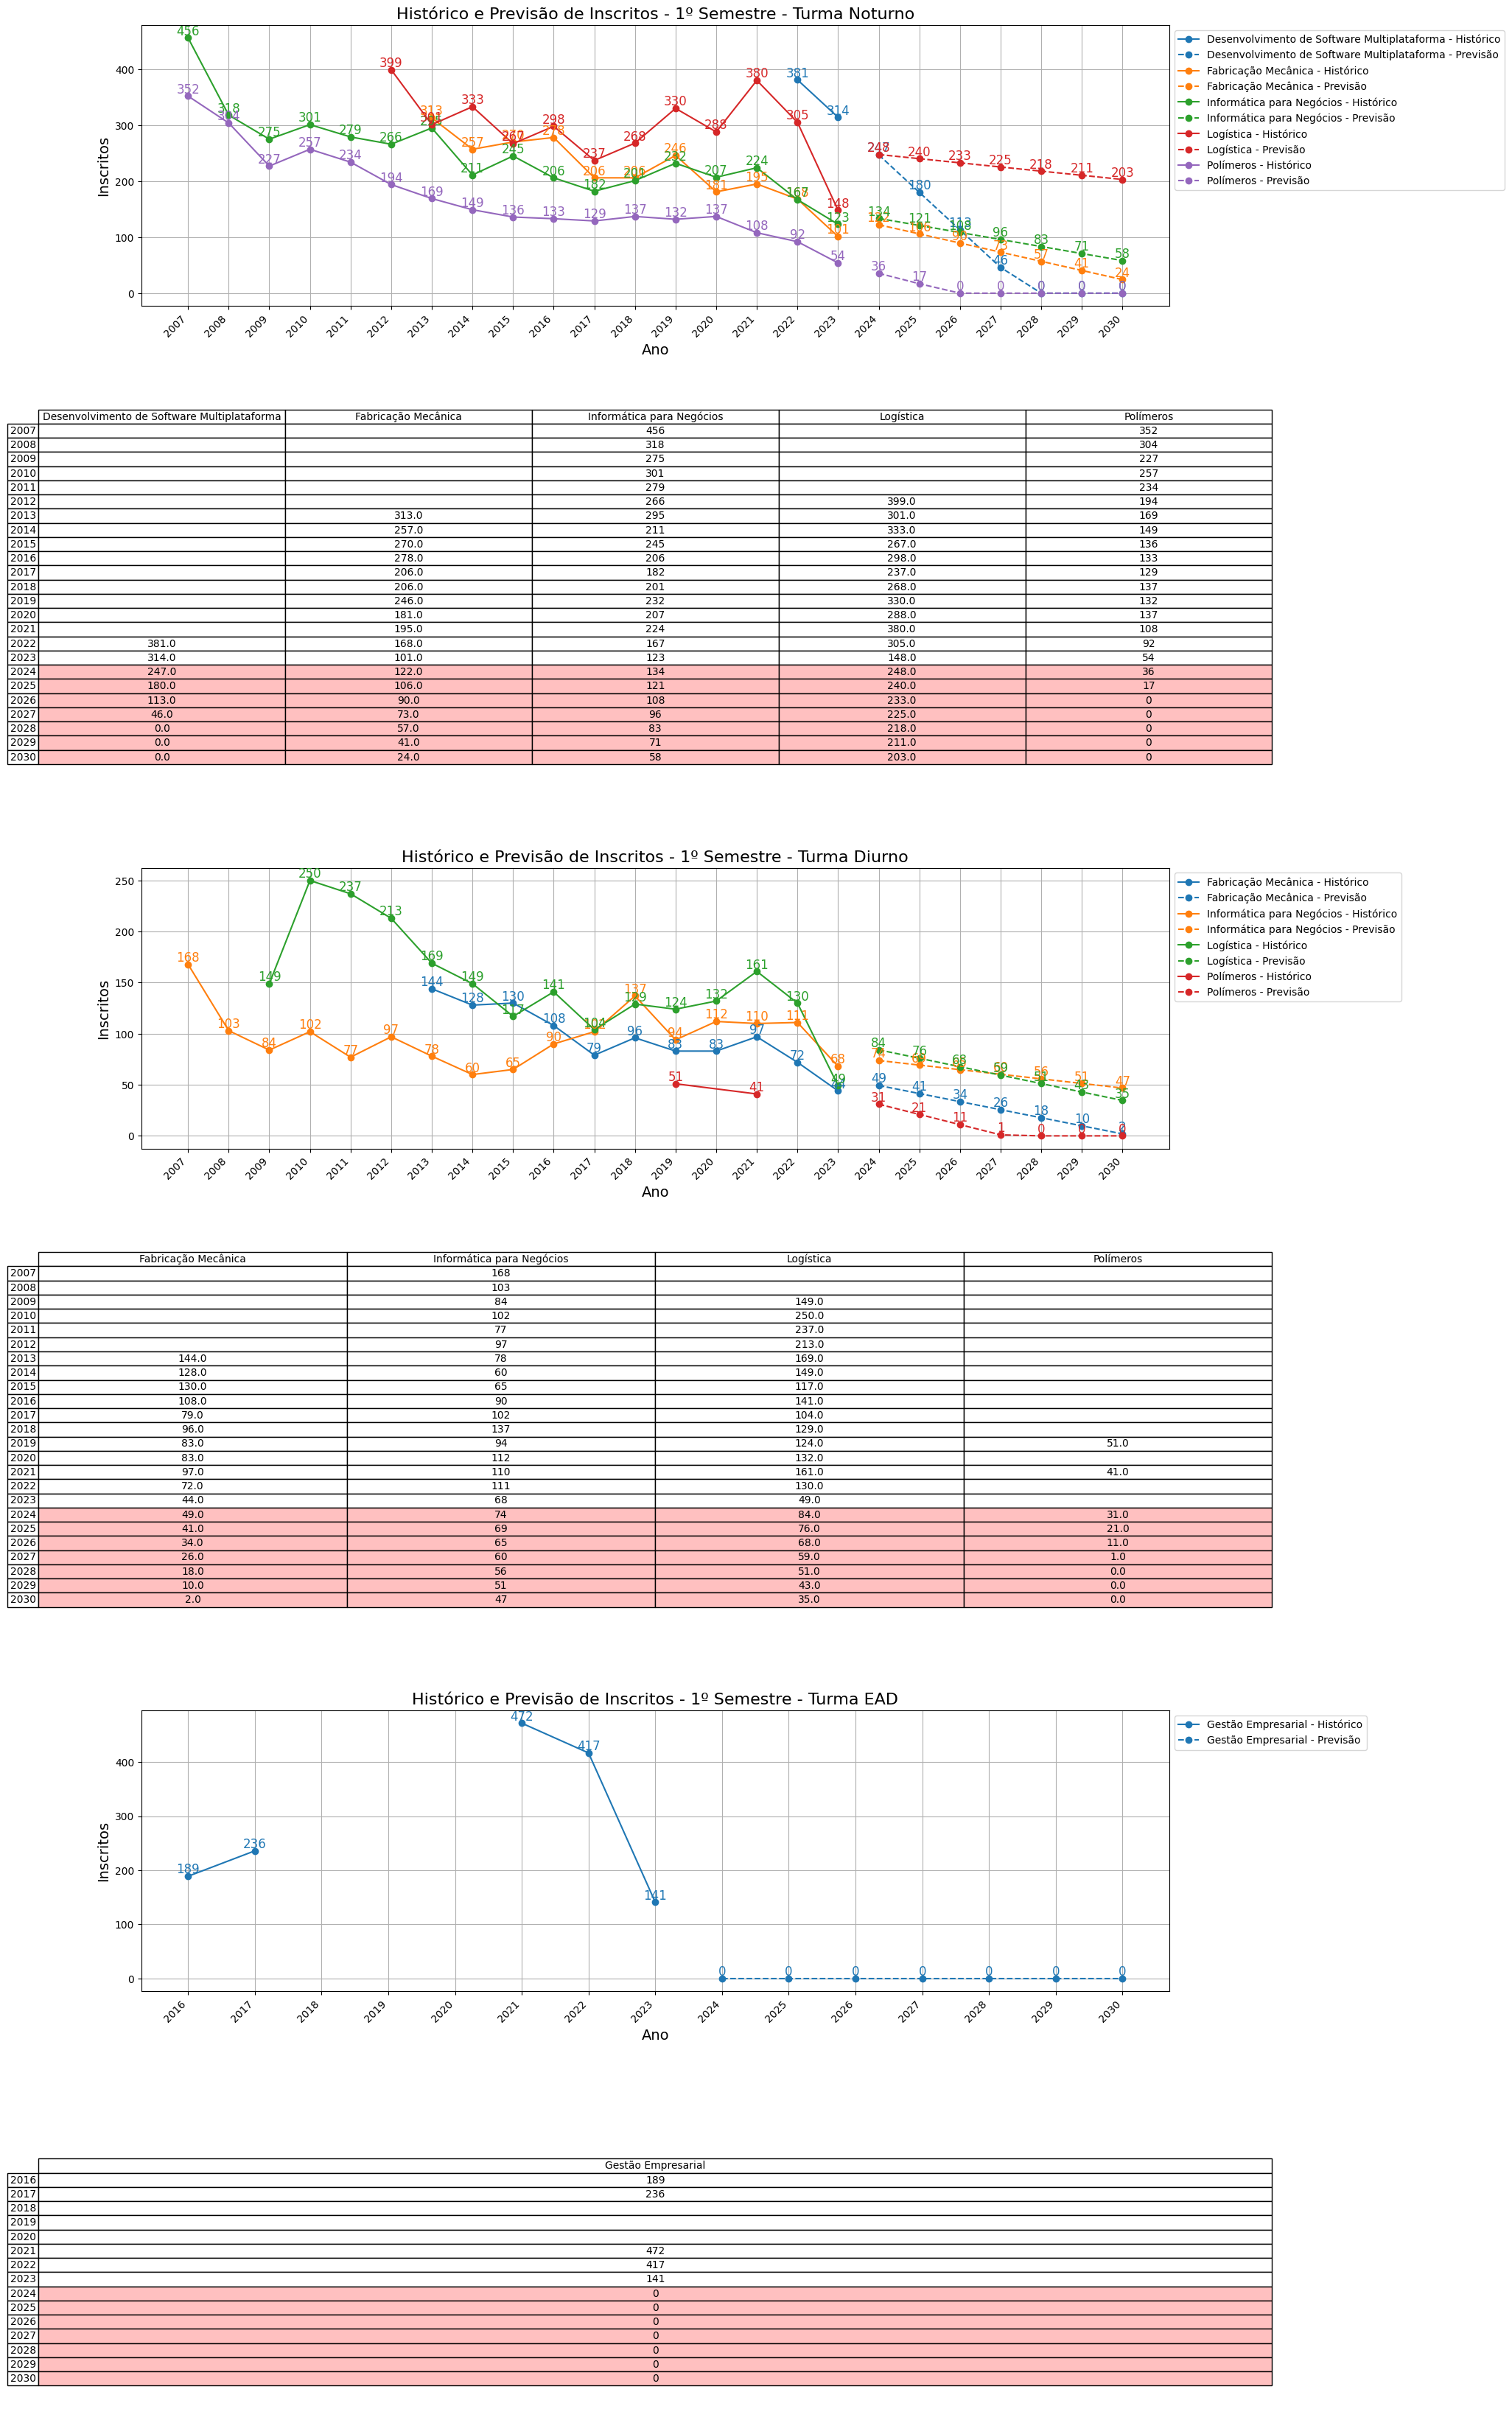

In [ ]:
# ALGORITMO PREVISAO COM holt - DADOS 1 SEMESTRE - PREVISÃO C/ holt  - historico até 2023 e previsão após

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import matplotlib

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
warnings.filterwarnings("ignore")

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        # Ajuste EAD
        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # Limitar histórico até 2023
        df_curso = df_curso[df_curso['Ano'] <= 2023]

        df_curso = df_curso.set_index('Ano').sort_index()
        y = df_curso['Inscritos']

        if len(y.dropna()) < 2:
            continue

        y_interp = y.interpolate(method='linear')

        try:
        #    modelo = ExponentialSmoothing(y_interp, trend='add', damped_trend=True, seasonal=None)
            modelo = ExponentialSmoothing(y_interp, trend='add', seasonal=None)

            ajuste = modelo.fit(optimized=True)
        except Exception as e:
            print(f"Erro no ajuste para {curso} na turma {turma}: {e}")
            continue

        # Previsão de 2024 até 2030
        anos_futuros = list(range(2024, 2031))
        forecast = ajuste.forecast(len(anos_futuros)).clip(lower=0)

        # Combinar histórico + previsão
        anos_todos = list(y.index) + anos_futuros
        valores_historico = y.values
        valores_previsao = forecast.values

        # Plot histórico
        ax_grafico.plot(y.index, valores_historico, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y_val in zip(y.index, valores_historico):
            if pd.notna(y_val):
                ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, ha='center', va='bottom', color=colors(i))

        # Plot previsão
        ax_grafico.plot(anos_futuros, valores_previsao, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y_val in zip(anos_futuros, valores_previsao):
            ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, ha='center', va='bottom', color=colors(i))

        anos_para_ticks.update(anos_todos)

        # Construir tabela
        for ano, valor in zip(y.index, valores_historico):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

        for ano, valor in zip(anos_futuros, valores_previsao):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

    # Configurar gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma}', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Criar tabela
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index().fillna('')

        cell_colors = []
        for ano in df_tabela.index:
            if ano >= 2024:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


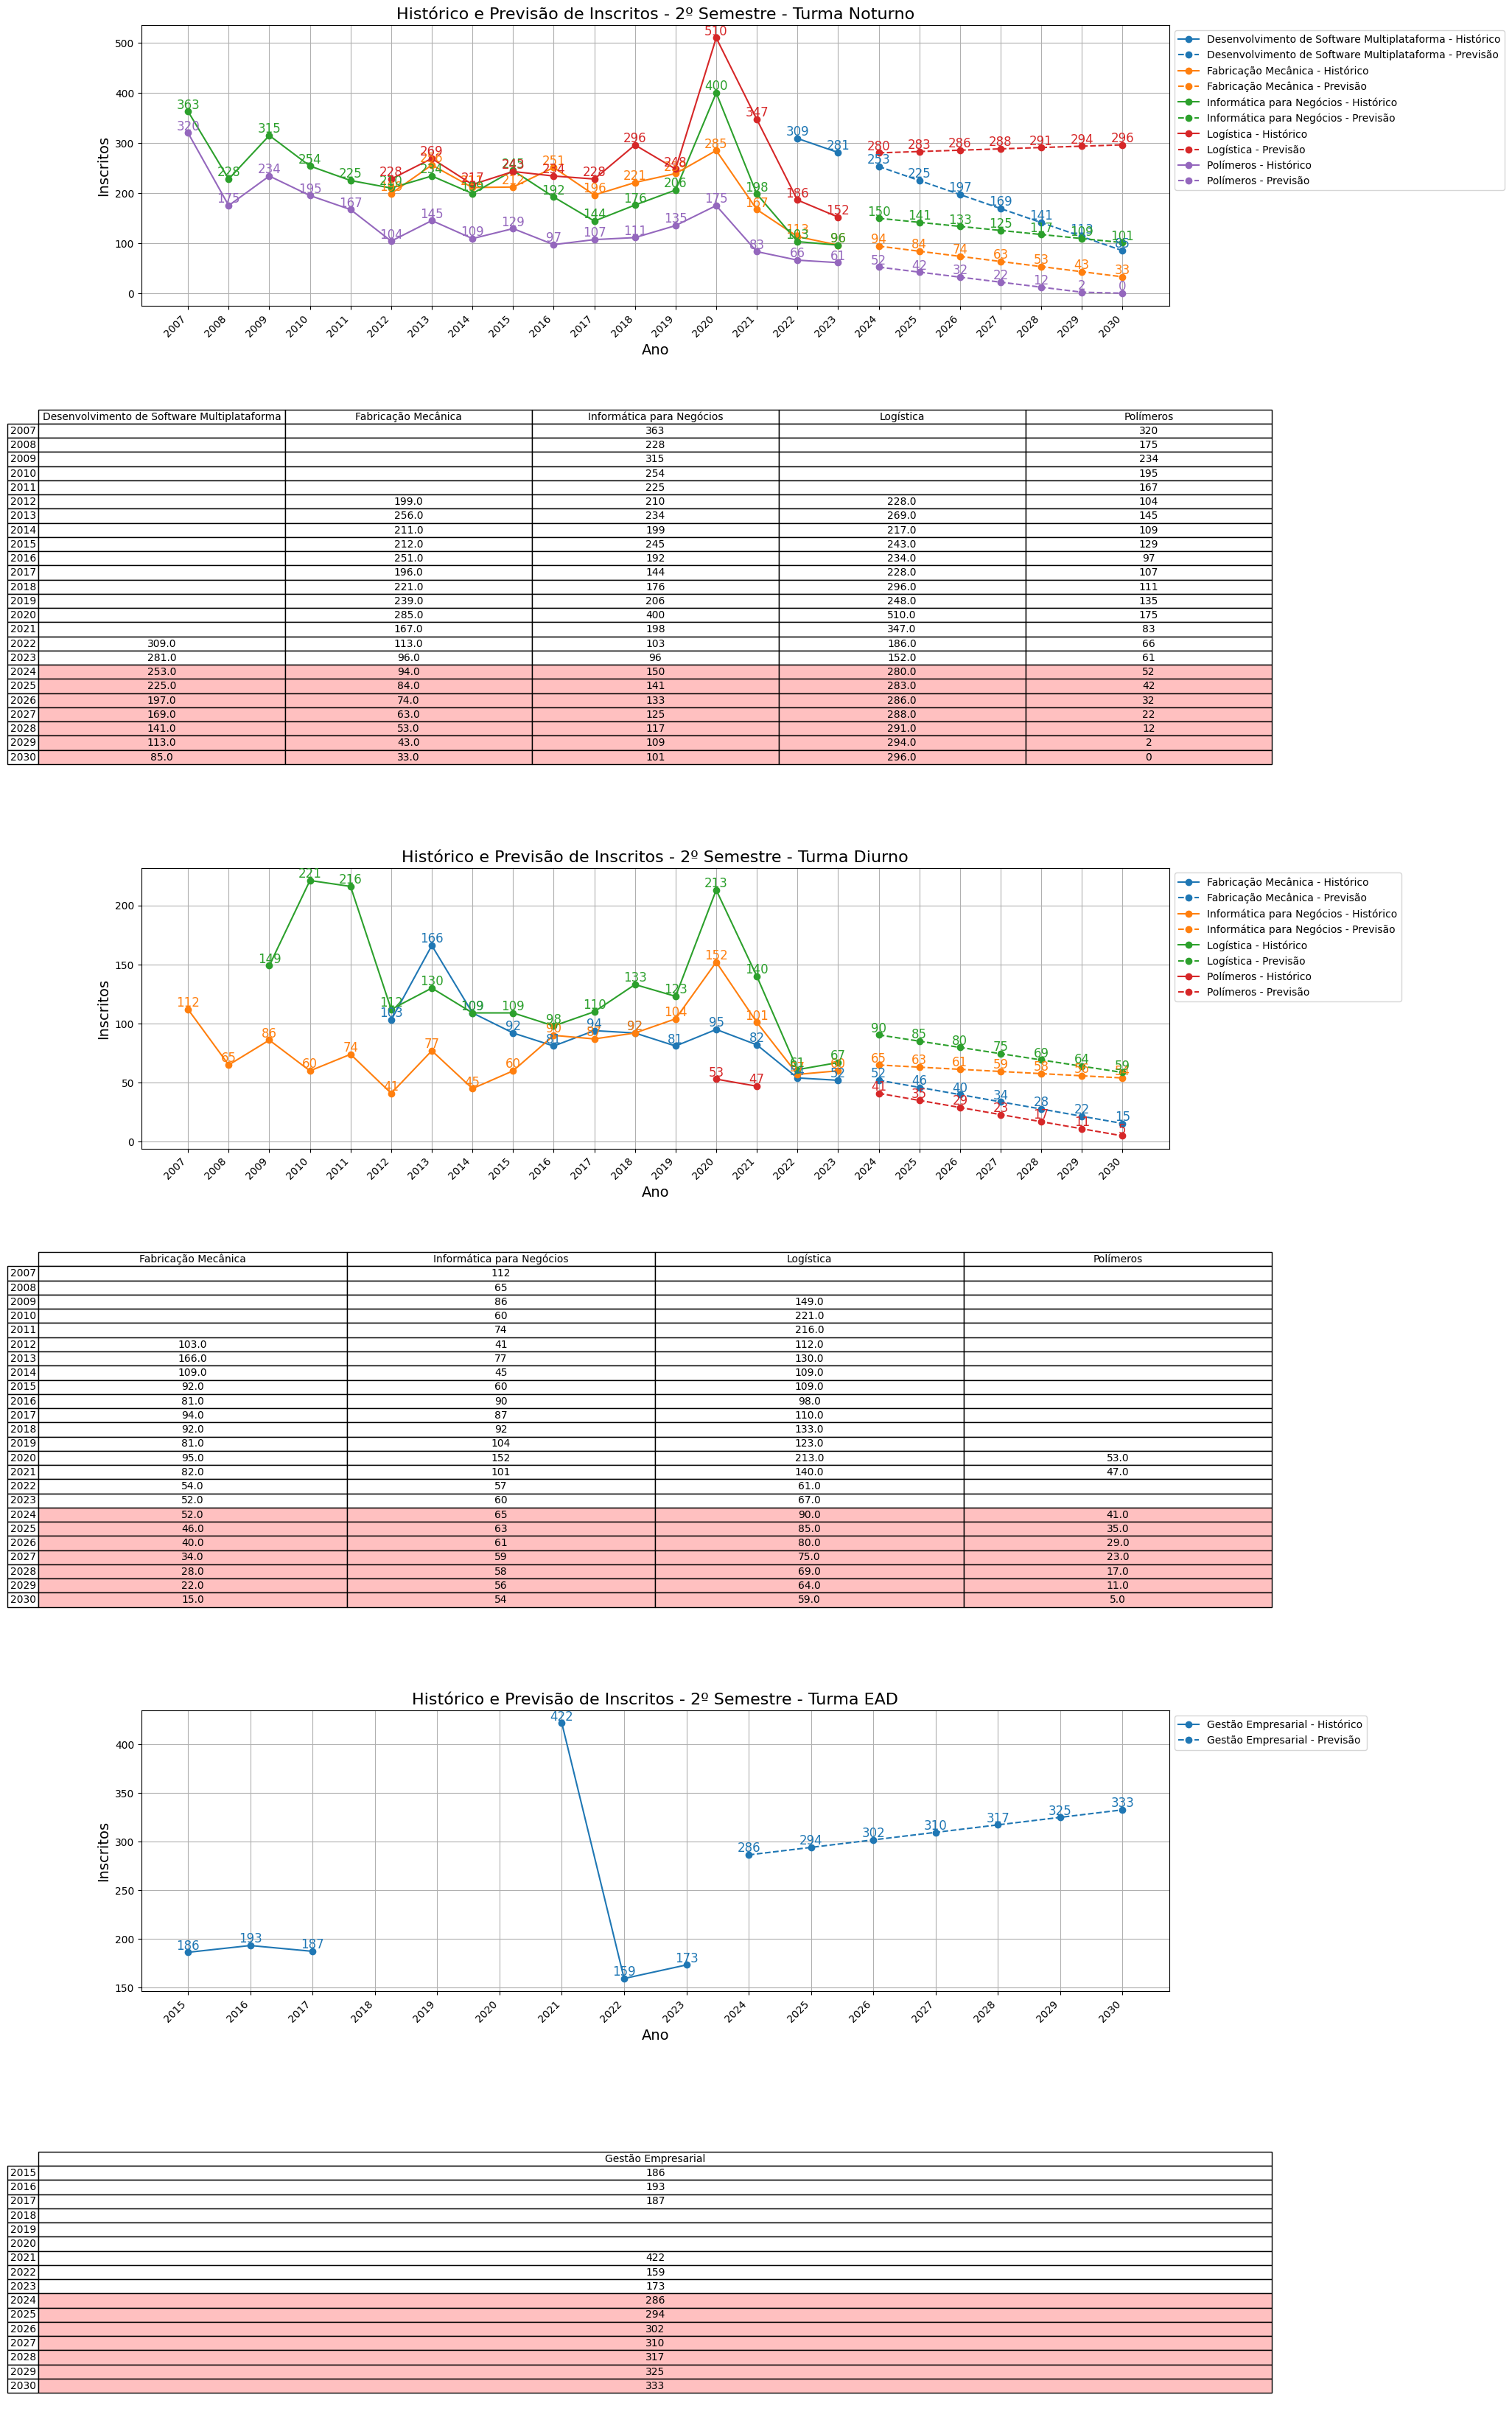

In [ ]:
# ALGORITMO PREVISAO COM holt - DADOS 1 SEMESTRE - PREVISÃO C/ holt  - historico até 2023 e previsão após

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import matplotlib

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
warnings.filterwarnings("ignore")

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 2:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        # Ajuste EAD
        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        # Limitar histórico até 2023
        df_curso = df_curso[df_curso['Ano'] <= 2023]

        df_curso = df_curso.set_index('Ano').sort_index()
        y = df_curso['Inscritos']

        if len(y.dropna()) < 2:
            continue

        y_interp = y.interpolate(method='linear')

        try:
        #    modelo = ExponentialSmoothing(y_interp, trend='add', damped_trend=True, seasonal=None)
            modelo = ExponentialSmoothing(y_interp, trend='add', seasonal=None)

            ajuste = modelo.fit(optimized=True)
        except Exception as e:
            print(f"Erro no ajuste para {curso} na turma {turma}: {e}")
            continue

        # Previsão de 2024 até 2030
        anos_futuros = list(range(2024, 2031))
        forecast = ajuste.forecast(len(anos_futuros)).clip(lower=0)

        # Combinar histórico + previsão
        anos_todos = list(y.index) + anos_futuros
        valores_historico = y.values
        valores_previsao = forecast.values

        # Plot histórico
        ax_grafico.plot(y.index, valores_historico, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y_val in zip(y.index, valores_historico):
            if pd.notna(y_val):
                ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, ha='center', va='bottom', color=colors(i))

        # Plot previsão
        ax_grafico.plot(anos_futuros, valores_previsao, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y_val in zip(anos_futuros, valores_previsao):
            ax_grafico.text(x, y_val, f'{int(round(y_val))}', fontsize=12, ha='center', va='bottom', color=colors(i))

        anos_para_ticks.update(anos_todos)

        # Construir tabela
        for ano, valor in zip(y.index, valores_historico):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

        for ano, valor in zip(anos_futuros, valores_previsao):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if pd.notna(valor) else ''

    # Configurar gráfico
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 2º Semestre - Turma {turma}', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Criar tabela
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index().fillna('')

        cell_colors = []
        for ano in df_tabela.index:
            if ano >= 2024:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy --upgrade --force-reinstall --no-cache-dir
!pip install pmdarima --no-cache-dir


Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Successfully uninstalled numpy-2.3.0
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 75.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.5 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade numpy
!pip uninstall -y pmdarima
!pip install pmdarima --no-cache-dir


Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y numpy pmdarima


Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Successfully uninstalled numpy-2.3.0
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4


In [ ]:
!pip install numpy==1.24.3
!pip install pmdarima==2.0.3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

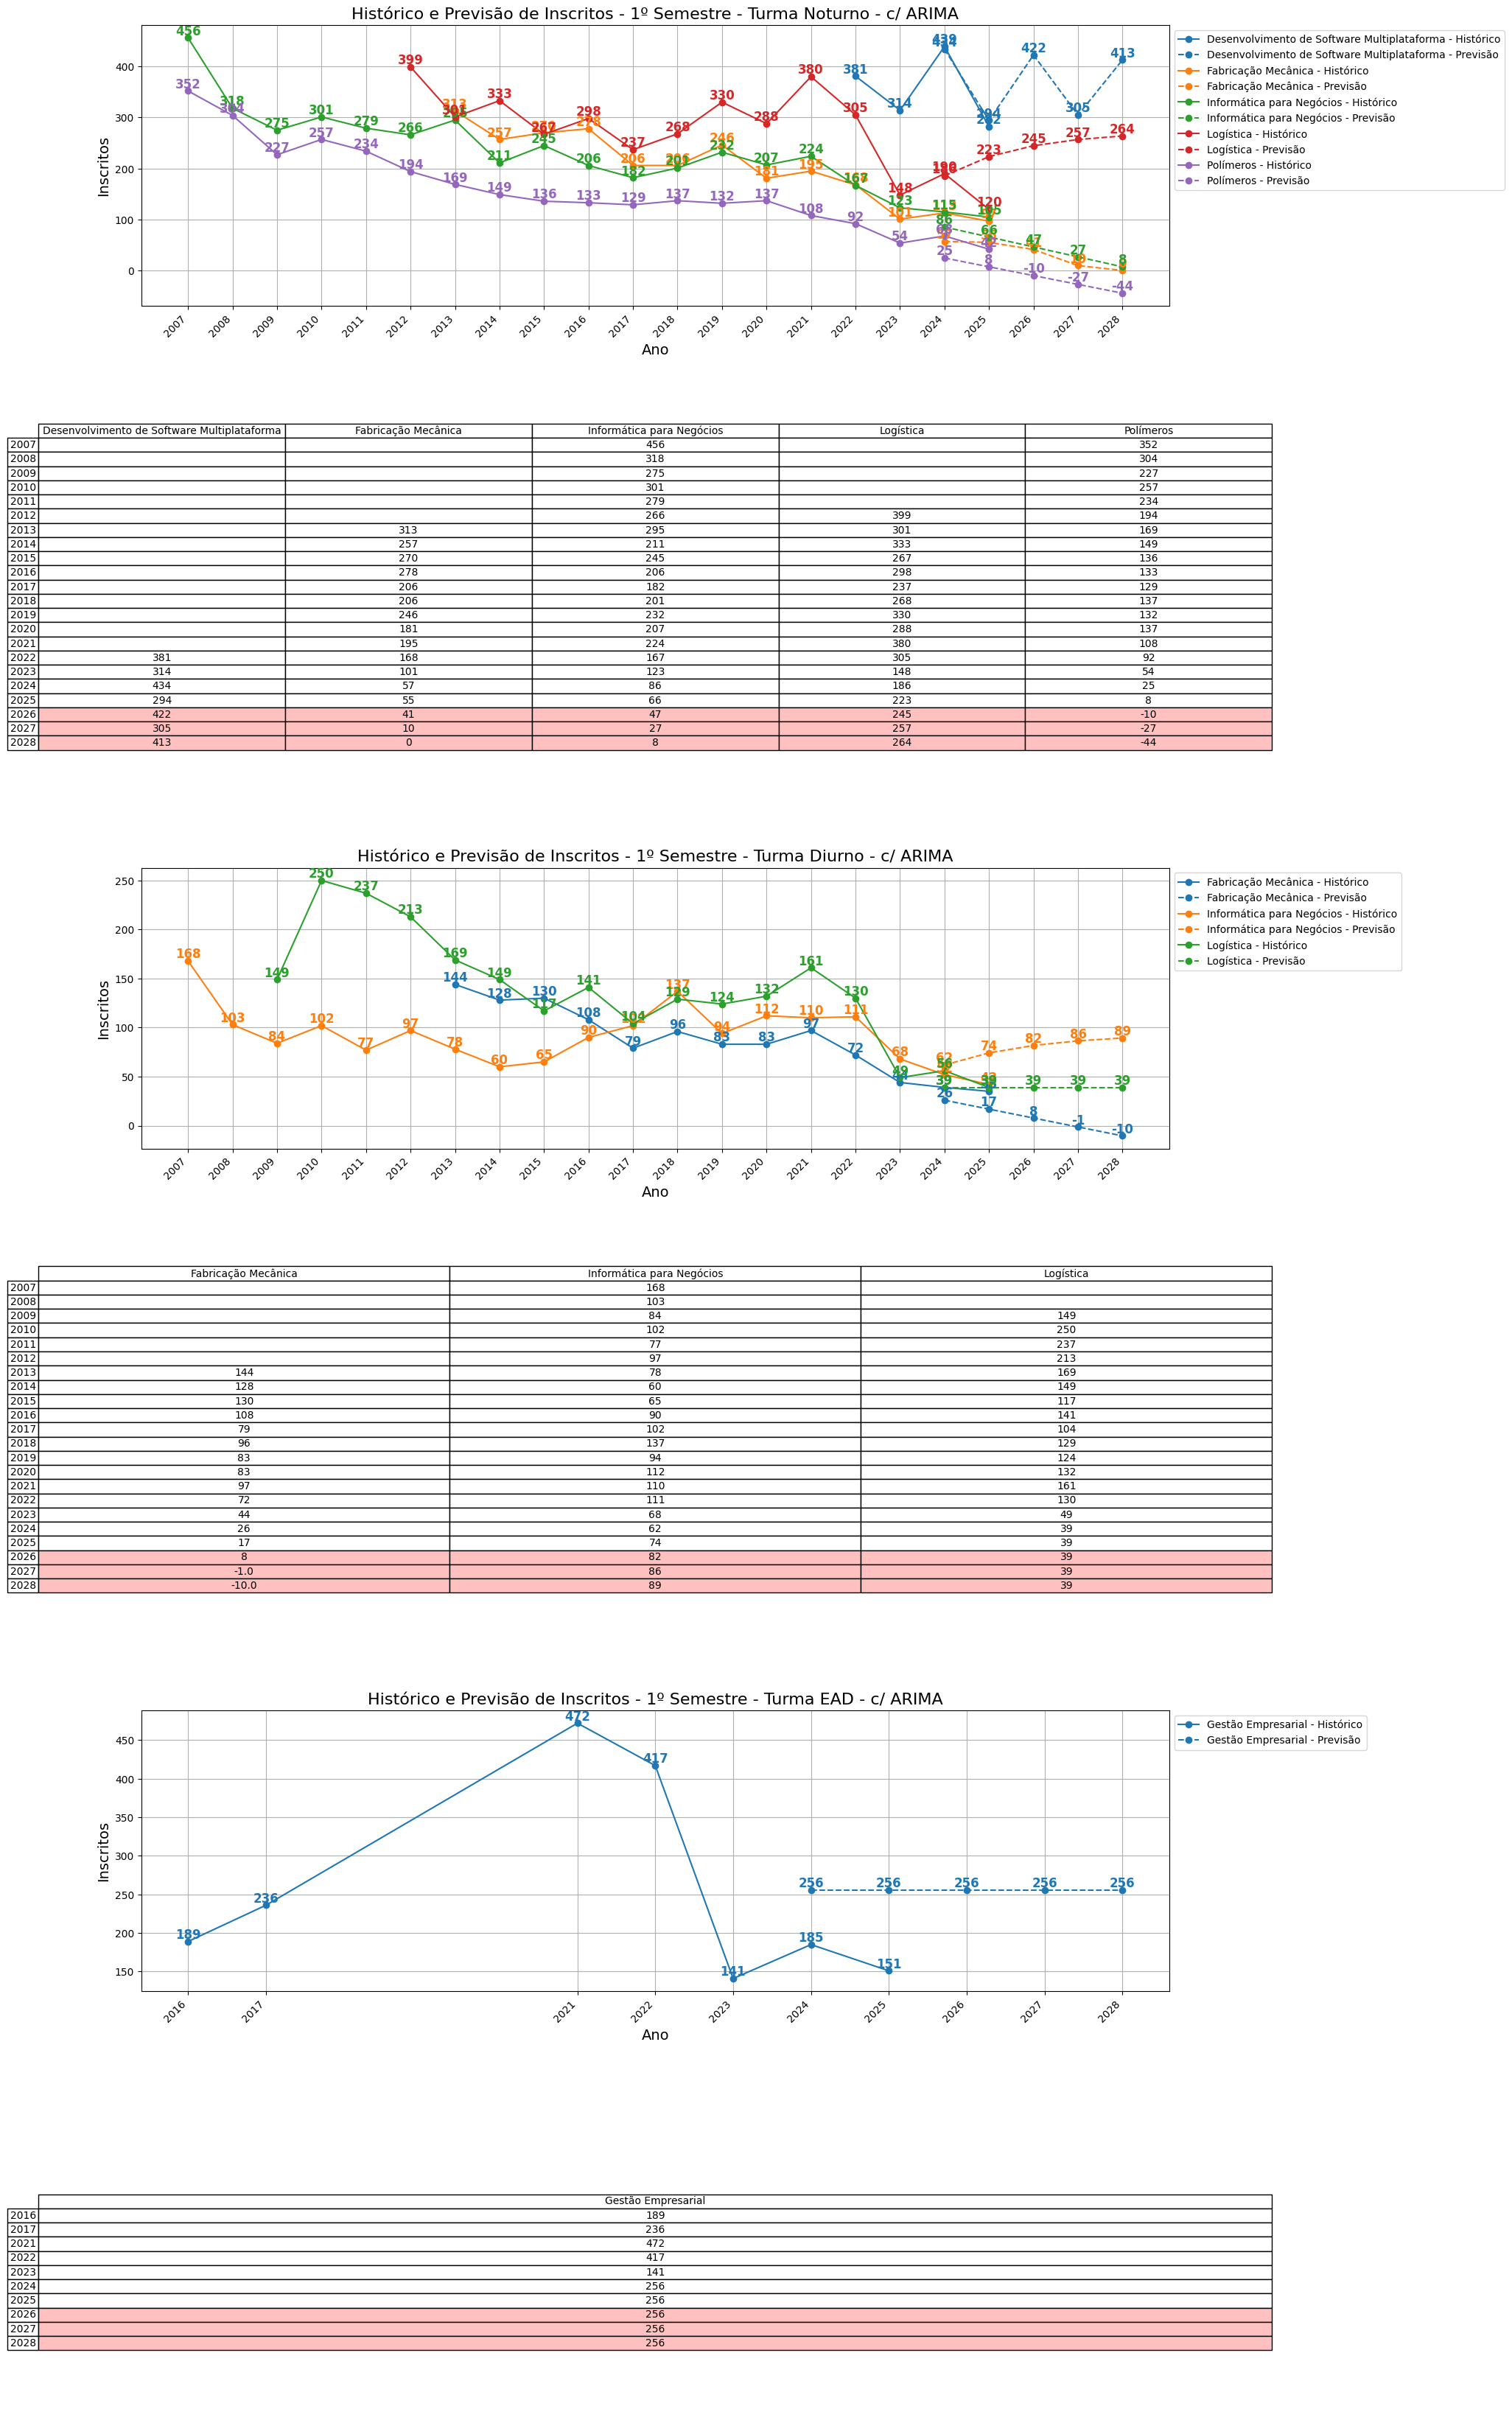

In [ ]:
# ALGORITMO PREVISAO COM ARIMA - DADOS 1 SEMESTRE

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib
import logging

from pmdarima import auto_arima
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 1]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_curso = df_curso.dropna()

        if len(df_curso) < 3:
            continue

        df_curso = df_curso.sort_values('Ano')
        serie = df_curso.set_index('Ano')['Inscritos']

        modelo = auto_arima(serie, seasonal=False, suppress_warnings=True)

        anos_existentes = serie.index.tolist()

        # Previsão fixa sempre a partir de 2024 até 2028
        anos_futuros = list(range(2024, 2029))
        n_periodos = len(anos_futuros)
        previsoes = modelo.predict(n_periods=n_periodos)

        anos_total = anos_existentes + anos_futuros
        valores_total = list(serie.values) + list(previsoes)

        ax_grafico.plot(anos_existentes, serie.values, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(anos_existentes, serie.values):
            ax_grafico.text(x, y, str(int(y)), fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        ax_grafico.plot(anos_futuros, previsoes, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(anos_futuros, previsoes):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        for ano, valor in zip(anos_total, valores_total):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if not pd.isna(valor) else ''

        anos_para_ticks.update(anos_total)

    # Eixo X
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ ARIMA', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Tabela abaixo
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x))

        df_tabela = df_tabela.astype(str)

        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

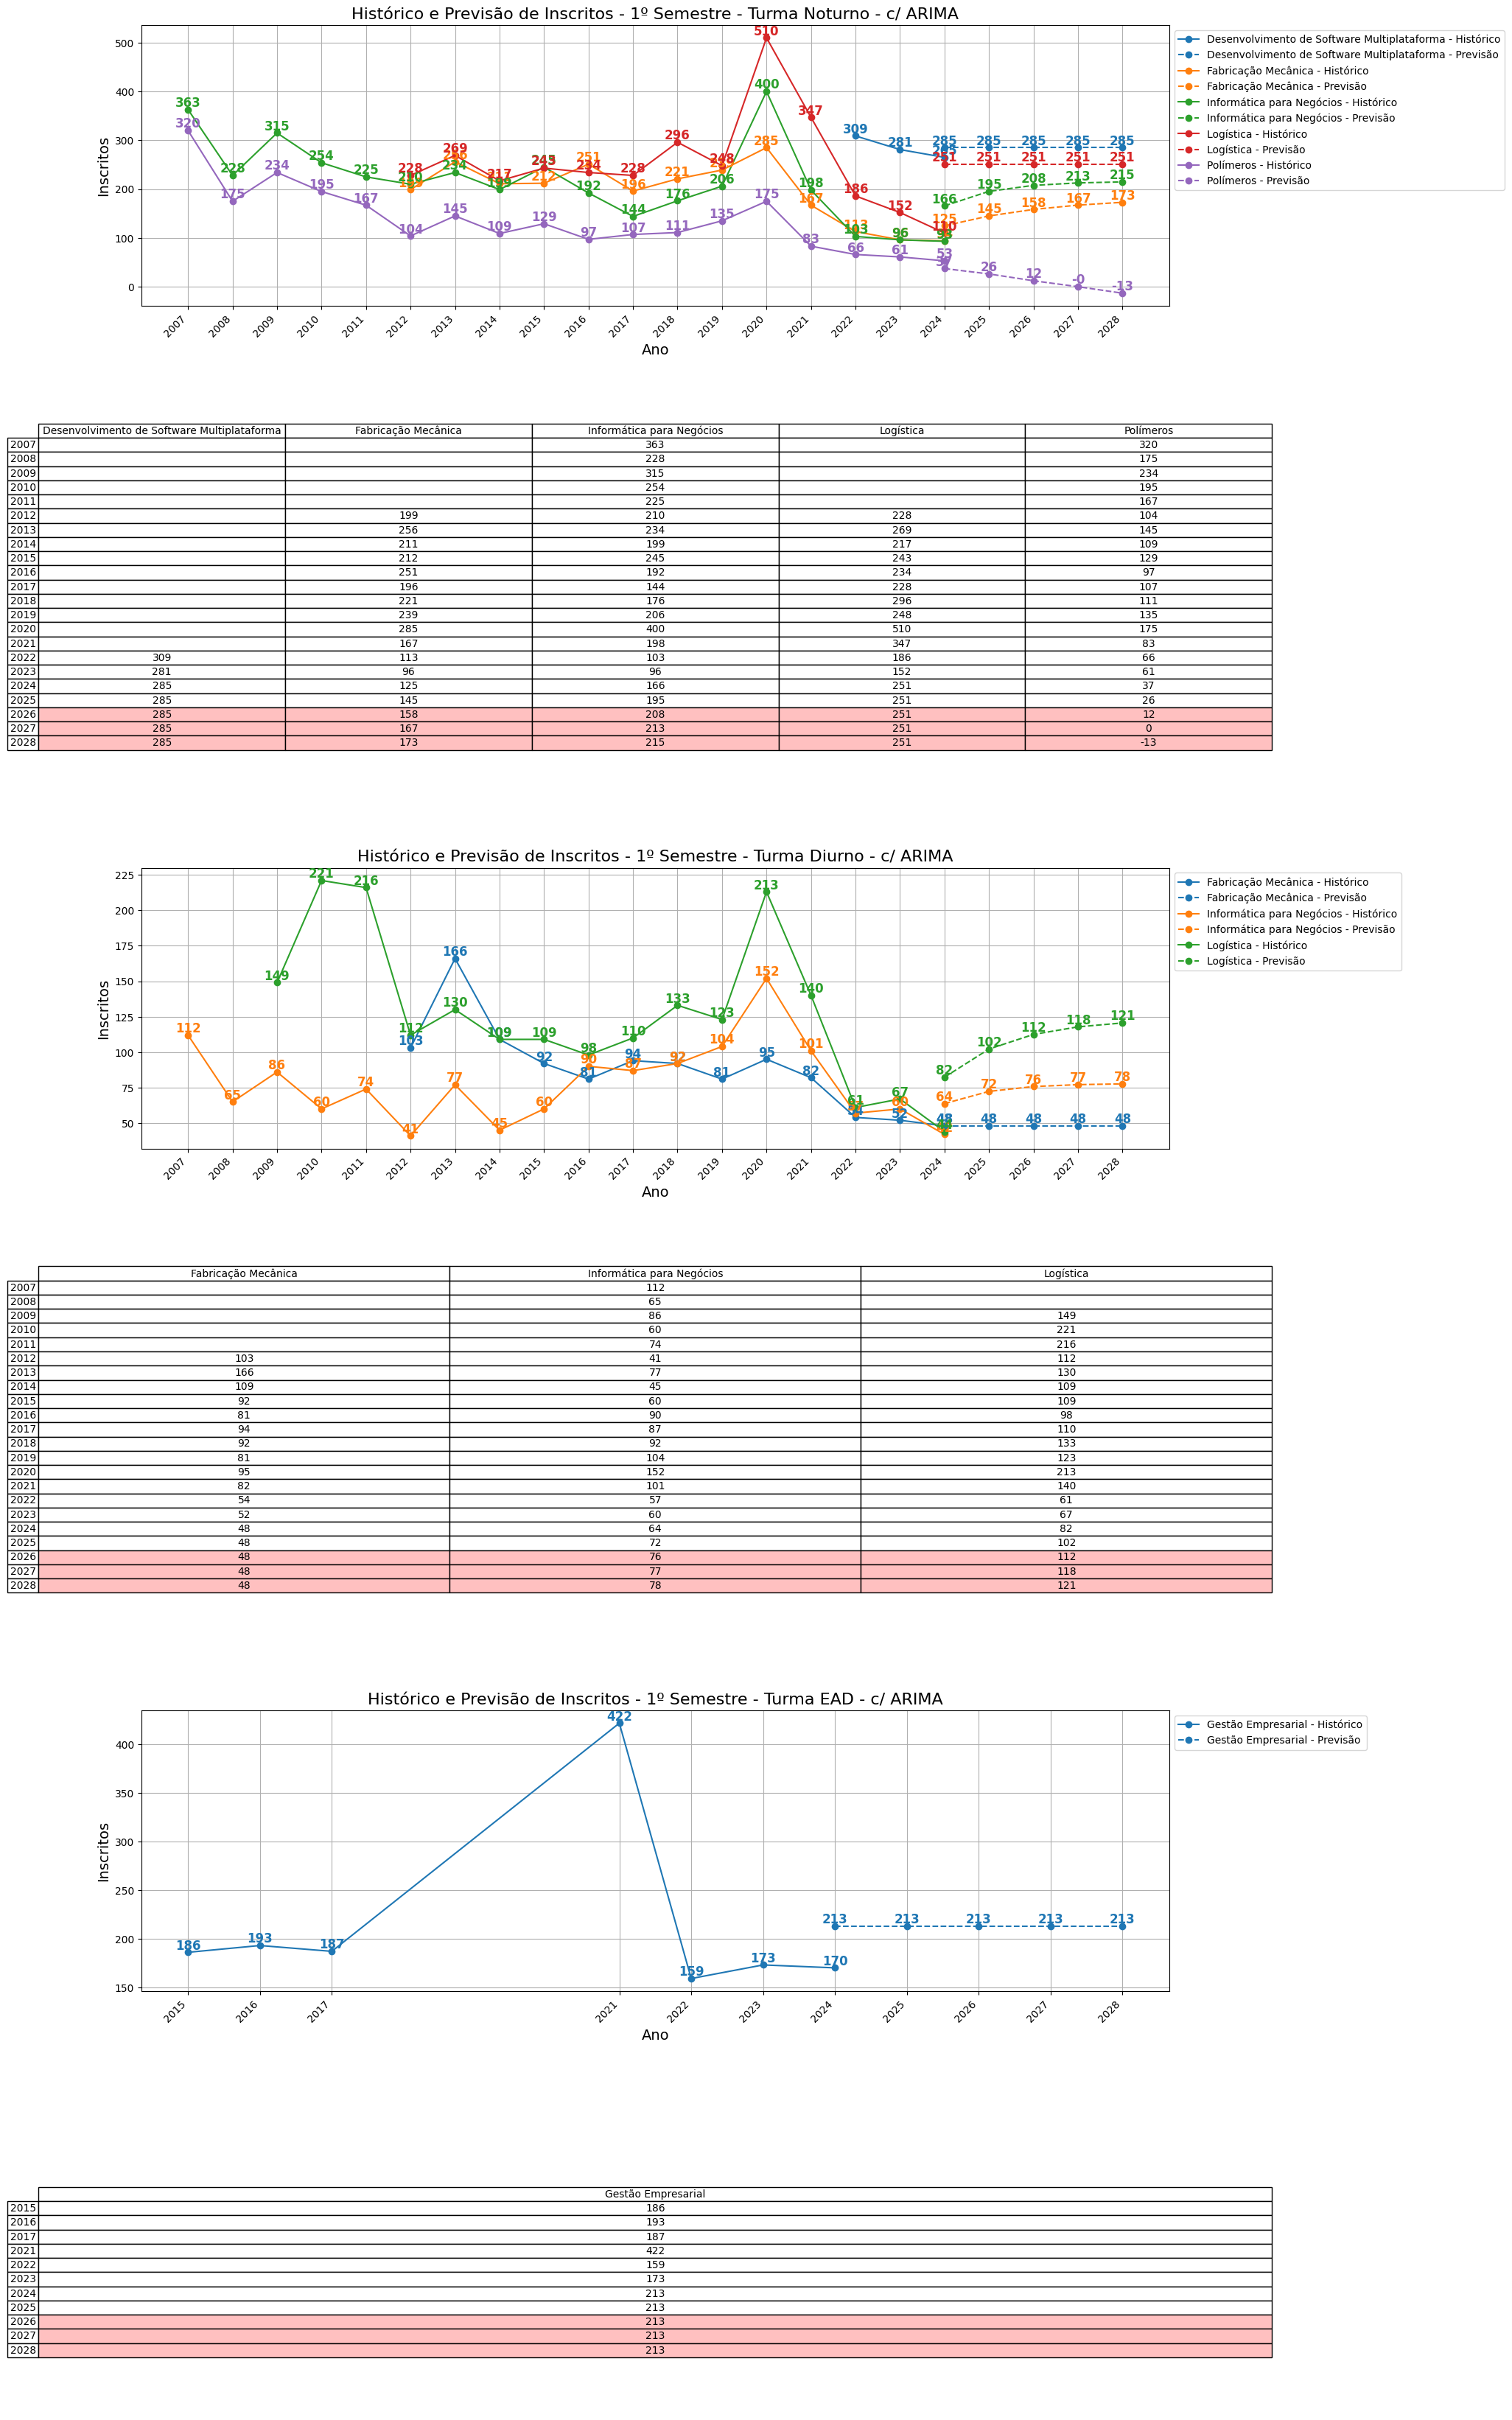

In [ ]:
# ALGORITMO PREVISAO COM ARIMA - DADOS 1 SEMESTRE

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib
import logging

from pmdarima import auto_arima
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning, module=matplotlib.__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Carregar os dados
df = pd.read_excel('Vestibular_tab_Completa.xlsx')

# Filtrar somente Semestre == 1
df = df[df['Semestre'] == 2]

# Garantir que colunas estão no formato certo
df['Ano'] = df['Ano'].astype(int)
df['Inscritos'] = pd.to_numeric(df['Inscritos'], errors='coerce')
df = df.dropna(subset=['Inscritos'])

# Obter todas as turmas
turmas = df['Turma'].unique()

# Criar figura com subplots, 2 linhas por turma (gráfico + tabela)
fig, axs = plt.subplots(nrows=len(turmas)*2, ncols=1, figsize=(18, 6 * len(turmas)*2))

if len(turmas) == 1:
    axs = [axs[0], axs[1]]

colors = plt.colormaps.get_cmap('tab10')

for idx, turma in enumerate(turmas):
    ax_grafico = axs[idx*2]
    ax_tabela = axs[idx*2 + 1]

    df_turma = df[df['Turma'] == turma]
    cursos = df_turma['NomeCurso'].unique()

    anos_para_ticks = set()
    tabela_dados = {}

    for i, curso in enumerate(cursos):
        df_curso = df_turma[df_turma['NomeCurso'] == curso].copy()
        df_curso = df_curso.groupby('Ano')['Inscritos'].sum().reset_index()

        if turma.upper() == 'EAD':
            for ano_faltante in [2018, 2019, 2020]:
                if ano_faltante not in df_curso['Ano'].values:
                    df_curso = pd.concat([
                        df_curso,
                        pd.DataFrame({'Ano': [ano_faltante], 'Inscritos': [float('nan')]})
                    ], ignore_index=True)
            df_curso = df_curso.sort_values('Ano')

        df_curso = df_curso.dropna()

        if len(df_curso) < 3:
            continue

        df_curso = df_curso.sort_values('Ano')
        serie = df_curso.set_index('Ano')['Inscritos']

        modelo = auto_arima(serie, seasonal=False, suppress_warnings=True)

        anos_existentes = serie.index.tolist()

        # Previsão fixa sempre a partir de 2024 até 2028
        anos_futuros = list(range(2024, 2029))
        n_periodos = len(anos_futuros)
        previsoes = modelo.predict(n_periods=n_periodos)

        anos_total = anos_existentes + anos_futuros
        valores_total = list(serie.values) + list(previsoes)

        ax_grafico.plot(anos_existentes, serie.values, marker='o', linestyle='-', color=colors(i), label=f'{curso} - Histórico')
        for x, y in zip(anos_existentes, serie.values):
            ax_grafico.text(x, y, str(int(y)), fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        ax_grafico.plot(anos_futuros, previsoes, marker='o', linestyle='--', color=colors(i), label=f'{curso} - Previsão')
        for x, y in zip(anos_futuros, previsoes):
            ax_grafico.text(x, y, f'{y:.0f}', fontsize=12, fontweight='bold', ha='center', va='bottom', color=colors(i))

        for ano, valor in zip(anos_total, valores_total):
            if ano not in tabela_dados:
                tabela_dados[ano] = {}
            tabela_dados[ano][curso] = int(round(valor)) if not pd.isna(valor) else ''

        anos_para_ticks.update(anos_total)

    # Eixo X
    anos_para_ticks = sorted(list(anos_para_ticks))
    ax_grafico.set_xticks(anos_para_ticks)
    ax_grafico.set_xticklabels([str(ano) for ano in anos_para_ticks], rotation=45, ha='right')

    ax_grafico.set_xlabel('Ano', fontsize=14)
    ax_grafico.set_ylabel('Inscritos', fontsize=14)
    ax_grafico.set_title(f'Histórico e Previsão de Inscritos - 1º Semestre - Turma {turma} - c/ ARIMA', fontsize=16)
    ax_grafico.grid(True)
    ax_grafico.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    # Tabela abaixo
    if tabela_dados:
        df_tabela = pd.DataFrame.from_dict(tabela_dados, orient='index')
        df_tabela = df_tabela.sort_index()
        for col in df_tabela.columns:
            df_tabela[col] = df_tabela[col].apply(lambda x: str(int(float(x))) if pd.notna(x) and x != '-' and str(x).replace('.', '', 1).isdigit() else ('' if pd.isna(x) else x))

        df_tabela = df_tabela.astype(str)

        cell_colors = []
        for ano in df_tabela.index:
            if ano in [2026, 2027, 2028]:
                cell_colors.append(['#FFC0C0'] * len(df_tabela.columns))
            else:
                cell_colors.append(['white'] * len(df_tabela.columns))

        ax_tabela.axis('off')
        table = ax_tabela.table(
            cellText=df_tabela.values,
            rowLabels=[str(ano) for ano in df_tabela.index],
            colLabels=df_tabela.columns.tolist(),
            cellLoc='center',
            cellColours=cell_colors,
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

plt.subplots_adjust(hspace=0.5, bottom=0.05, top=0.95)
plt.show()
